In [1]:
import sys
print(sys.executable)
print(sys.version)


C:\Users\giupiz\AppData\Local\anaconda3\envs\ephys\python.exe
3.7.16 (default, Jan 17 2023, 16:06:28) [MSC v.1916 64 bit (AMD64)]


In [2]:
# pip show pandas

# IF THINGS MYSTERIOUSLY FAIL
# on Aug 7th we switched the statsmodels to a higher version. To enable this, we also upgraded pandas

# Old statsmodels 0.9.0, new is 0.13.5
# pip install statsmodels --upgrade --user
# Old/new pandas 1.3.5 - unsure if this is acc... ran before checking, might have finished
# pip install pandas --upgrade --user


In [1]:
import os

import pyabf
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from ipfx.feature_extractor import (SpikeFeatureExtractor, SpikeTrainFeatureExtractor)
import ipfx
import efel
import pyabf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import nanmean
import openpyxl
from scipy.optimize import curve_fit

import statsmodels.api as ssm

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [45]:
# Set the file path
data='24415007_2y_M1_1.abf'
#data ='E:/Ken/Sag_firing_rate/M1_A2_23d12008.abf'
abf = pyabf.ABF(data)
abf_c = pyabf.ABF(data)

# print (abf)  # Optional: extract information from the ABF file


In [6]:
# Set the table from the dataframe below
dataframe = [] 

# Loop function to analyze each voltage trace of the file
for sweepNumber in abf.sweepList: # e.g. abf.sweepList[1:3] to select the range
    #print(sweepNumber)
    abf.setSweep(sweepNumber, channel = channel)
    abf_c.setSweep(sweepNumber, channel = channel_c)

    time = abf.sweepX
    voltage = abf.sweepY
    current = abf_c.sweepC

    # Define the region (in seconds)
#     start = start
#     end = end
    # Parameters for analysis: 
    # Filter = None to avoid conflicts with your recording settings
    # dv/dt cutoff (mV/ms), min_peak (mV)
    sfx = SpikeFeatureExtractor(start, end, 
                                filter=None, 
                               ) 

    sfx_results = sfx.process(time, voltage, current)

    dataframe.append(sfx_results)  # To get the mean: df.append(sfx_results.mean())
    
    #table = pd.concat(dataframe)
# Table with the features from all the action potentials
#IT GIVES ALL INFO ON VOLTAGE FROM IPFX (better second table!)
#table = pd.concat(dataframe)
#print(table.head())

NameError: name 'channel' is not defined

In [15]:
# Pupose: Creates charts 
# Input ABF file, 
# Outputs Charts. 
# Returns three plots

def create_all_charts(abf, abf_c, start, end, channel, channel_c, t1_c, t2_c, stim_start, stim_end):

    # Set the dataframe for the table
    table_2 = pd.DataFrame()

    # Loop function to analyze each voltage and current trace of the file
    for sweep in abf.sweepList:  # To select a range of traces
        abf.setSweep(sweep, channel = channel)
        abf_c.setSweep(sweep, channel = channel_c)
        # Defines a trace and region of analysis
        trace = {'T': abf.sweepX*1000, # convert to ms
                 'V': abf.sweepY,
                 'I': abf_c.sweepC,
                 'stim_start' : [stim_start],
                 'stim_end' : [stim_end]}
        traces = [trace]
        
        currents = [] # Current value between t1 and t2 (ms) for each step
        t1 = int(t1_c*abf.dataPointsPerMs) 
        t2 = int(t2_c*abf.dataPointsPerMs)
        current_mean = np.average(abf_c.sweepC[t1:t2])

        # Output features
        feature_values = efel.getFeatureValues(traces,
                                               ['Spikecount', 
                                                'current'],
                                               raise_warnings=None)[0] # If true, returns warnings

        # Optional: create table from the results
        # Use [0] to extract the values from the Spikecount array
        
        length = len(table_2)
        table_2.loc[length, 'Sweep'] = sweep
        table_2.loc[length, 'Spikecount'] = feature_values['Spikecount'][0]
        table_2.loc[length, 'current_pA'] = current_mean # [] to select the rows of current step
    # Optional Plotting: example with three subplots
    fig = plt.figure(figsize=(15, 5))

    # Input-output curve
    ax1 = fig.add_subplot(1, 2, 1)
    currents = []
    for sweep in abf.sweepList:
        abf.setSweep(sweep)
        abf_c.setSweep(sweep, channel = channel_c)
        currents.append(np.average(abf_c.sweepC[t1:t2]))
    ax1.plot(currents, table_2.loc[:,'Spikecount'])
    ax1.set_xlabel('Current step (pA)')
    ax1.set_ylabel('Number of spikes')

    # All traces
    ax2 = fig.add_subplot(2, 2, 2)
    for sweep in abf.sweepList:
        abf.setSweep(sweep)
        ax2.plot(abf.sweepX, abf.sweepY, alpha=.6, label="Sweep %d" % (sweepNumber))
    ax2.set_ylabel('Membrane voltage (mV)')
    # ax2.legend() # Optional
    # To highllight one trace
    abf.setSweep(10) 
    ax2.plot(abf.sweepX, abf.sweepY, linewidth=1, color='black')
    ax2.axes.set_xlim(0, 3) # Range of the x-axis (seconds)

    # All current steps
    ax3 = fig.add_subplot(2, 2, 4, sharex=ax2) 
    for sweep in abf.sweepList:
        abf.setSweep(sweep)
        abf_c.setSweep(sweep, channel = channel_c)
        current = abf_c.sweepC
        ax3.plot(abf.sweepX, current)
    ax3.set_ylabel("Current (pA)")
    ax3.set_xlabel("Time (s)")
    # To highllight one current trace
    abf.setSweep(13) 
    ax3.plot(abf.sweepX, abf_c.sweepC, linewidth=1, color='black')
    fig.tight_layout()

    # Optional: Export the graph (png) and the table (csv)
    #fig.savefig("Path/to/file/filename.png", dpi=300)
    #table.to_csv('Path/to/file/filename.csv')

    # Show the graph and the table results 
    plt.show()


 
def create_plot_firing_current(abf, abf_c, start, end, channel, channel_c, t1_c, t2_c, stim_start, stim_end):
    # Set the dataframe for the table
    table_2 = pd.DataFrame()

    # Loop function to analyze each voltage and current trace of the file
    for sweep in abf.sweepList:  # To select a range of traces
        abf.setSweep(sweep, channel = channel)
        abf_c.setSweep(sweep, channel = channel_c)
        # Defines a trace and region of analysis
        trace = {'T': abf.sweepX*1000, # convert to ms
                 'V': abf.sweepY,
                 'I': abf_c.sweepC,
                 'stim_start' : [stim_start],
                 'stim_end' : [stim_end]}
        traces = [trace]
        
        currents = [] # Current value between t1 and t2 (ms) for each step
        t1 = int(t1_c*abf.dataPointsPerMs) 
        t2 = int(t2_c*abf.dataPointsPerMs)
        current_mean = np.average(abf_c.sweepC[t1:t2])

        # Output features
        feature_values = efel.getFeatureValues(traces,
                                               ['Spikecount', 
                                                'current'],
                                               raise_warnings=None)[0] # If true, returns warnings

        # Optional: create table from the results
        # Use [0] to extract the values from the Spikecount array
        
        length = len(table_2)
        table_2.loc[length, 'Sweep'] = sweep
        table_2.loc[length, 'Spikecount'] = feature_values['Spikecount'][0]
        table_2.loc[length, 'current_pA'] = current_mean # [] to select the rows of current step
    # Optional Plotting: example with three subplots
    fig = plt.figure(figsize=(15, 5))

    # Input-output curve
    ax1 = fig.add_subplot(1, 2, 1)
    currents = []
    for sweep in abf.sweepList:
        abf.setSweep(sweep)
        abf_c.setSweep(sweep, channel = channel_c)
        currents.append(np.average(abf_c.sweepC[t1:t2]))
    ax1.plot(currents, table_2.loc[:,'Spikecount'])
    ax1.set_xlabel('Current step (pA)')
    ax1.set_ylabel('Number of spikes')

    return(fig)

def create_plot_input_resistance(abf, abf_c):
    # All traces
    fig = plt.figure(figsize=(15, 5))
    
    for sweep in abf.sweepList:
        abf.setSweep(sweep)
        plt.plot(abf.sweepX, abf.sweepY, alpha=.6, label="Sweep %d" % (sweepNumber))
    plt.ylabel('Membrane voltage (mV)')
    plt.xlabel('Time (ms)')
    # plt.legend() # Optional
    
    # To highllight one trace
    abf.setSweep(0) 
    plt.plot(abf.sweepX, abf.sweepY, linewidth=1, color='black')
    #plt.xlim([0, 3]) # Range of the x-axis (seconds)
    #plt.title('Input Resistance')

    return(fig)

def create_plot_input_resistance_currents(abf, abf_c):
    # Turn interactive plotting off
    plt.ioff()
    # All current steps
    fig = plt.figure(figsize=(15, 5))
    
    for sweep in abf.sweepList:
        abf.setSweep(sweep)
        abf_c.setSweep(sweep, channel = channel_c)
        current = abf_c.sweepC
        plt.plot(abf.sweepX, current, alpha=.6, label="Sweep %d" % (sweepNumber))
        
    plt.ylabel("Current (pA)")
    plt.xlabel("Time (s)")
    # To highllight one current trace
    #abf.setSweep(13) 
    #plt.plot(abf.sweepX, abf_c.sweepC, linewidth=1, color='black')
    #plt.title('Input Resistance Currents')
    
    return(fig)

#a, b, c = create_all_charts(abf, abf_c)  

# Dont need this one
#create_all_charts(abf, abf_c, start, end, channel, channel_c, t1_c, t2_c, stim_start, stim_end)
#a = create_plot_firing_current(abf, abf_c)
#b = create_plot_input_resistance(abf, abf_c)
#c = create_plot_input_resistance_currents(abf, abf_c)


In [11]:
# IPFX TABLE
#CHANGED 

def generate_ipfx_table(abf, abf_c, channel, channel_c, t1_c, t2_c, stim_start, stim_end):
    
    table_1 = pd.DataFrame()

    # Loop function to analyze each voltage and current trace of the file
    for sweep in abf.sweepList:
        abf.setSweep(sweep)
        abf_c.setSweep(sweep, channel = channel_c)

        time = abf.sweepX
        voltage = abf.sweepY
        current = abf_c.sweepC

        currents = [] # Current value between t1 and t2 (ms) for each step
        t1 = int(t1_c*abf.dataPointsPerMs) 
        t2 = int(t2_c*abf.dataPointsPerMs)
        current_mean = np.average(abf_c.sweepC[t1:t2])
        
        sfx = SpikeFeatureExtractor(start=(stim_start/1000), end=(stim_end/1000), filter=None)
        sfx_results = sfx.process(time, voltage, current)
        stfx = SpikeTrainFeatureExtractor (start=(stim_start/1000), end=(stim_end/1000))
        stfx_results = stfx.process(time, voltage, current, sfx_results)
        
#         ipfx.spike_train_features.get_isis
        # Create a table with the stfx results
        length = len(table_1)

        if stfx_results ['avg_rate'] > 0:
            table_1.loc[length, 'Sweep'] = sweep
            #table_1.loc[length, 'Current_step'] = current_mean
            #table_1.loc[length, 'Adaptation'] = stfx_results ["adapt"]
            #table_1.loc[length, 'Latency_s'] = stfx_results ["latency"] #Same as other table-> VERY GOOD
            table_1.loc[length, 'First ISI (ms)'] = stfx_results ["first_isi"]*1000
            #table_1.loc[length, 'ISI_last_ms'] = ipfx.spike_train_features.get_isis(1, -1)
            table_1.loc[length, 'Mean ISI (ms)'] = stfx_results ["mean_isi"]*1000
            table_1.loc[length, 'ISI CV'] = stfx_results ["isi_cv"]#Coefficient of variation
            #table_1.loc[length, 'Firing_rate_Hz'] = stfx_results ["avg_rate"]
            #table.loc[length, 'Rheobase'] = stfx_results ["rheobase"]
            #table.loc[length, 'Spikecount'] = stfx_results ['Spikecount_stimint']
    
    return(table_1)

#TEST

channel=0 #for recording
channel_c=0 #for current

start=0
end=1.9
#Current steps
t1_c=600
t2_c=601

#Start and end of stimulation (ms)
stim_start=115
stim_end=815

#data='E:/Ken_data/23d14/Mouse_B3/Firing_properties/23d14005_M3_B1.abf'
data='23414003.abf'
abf = pyabf.ABF(data)
abf_c = pyabf.ABF(data)

generate_ipfx_table(abf, abf_c, channel, channel_c, t1_c, t2_c, stim_start, stim_end)


C:\Users\giupiz\AppData\Local\anaconda3\envs\ephys\lib\site-packages\ipfx\spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]
C:\Users\giupiz\AppData\Local\anaconda3\envs\ephys\lib\site-packages\ipfx\spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]


,Sweep,First ISI (ms),Mean ISI (ms),ISI CV
0,11.0,198.5,205.600000,0.034533
1,12.0,114.1,126.720000,0.096679
2,13.0,84.7,92.950000,0.094607
3,14.0,59.1,78.612500,0.157558
4,15.0,46.4,71.144444,0.204057
5,16.0,37.5,64.900000,0.236837
6,17.0,31.7,60.518182,0.272036
7,18.0,30.6,55.308333,0.257347
8,19.0,24.5,51.858333,0.261273
9,20.0,21.8,48.846154,0.275957


In [23]:
# AP table
#data= 'E:/Ken_data/23d14/Mouse_B3/Firing_properties/23d14026_M3_B5.abf'

#CHANGED entire cell

def generate_AP_table(abf, abf_c, channel, channel_c, t1_c, t2_c, stim_start, stim_end):
    pd.set_option('display.max_columns', None)
    # Define the variables
    for sweep in abf.sweepList:
        abf.setSweep(sweep)
        abf_c.setSweep(sweep, channel = channel_c)
        time = abf.sweepX*1000 # in miliseconds
        voltage = abf.sweepY
        current = abf_c.sweepC

    # Define the variables and region of analysis
    trace = {'T': abf.sweepX*1000, 
             'V': abf.sweepY,
             'stim_start': [stim_start],
             'stim_end': [stim_end]} 
    traces = [trace]

    # Optional: Current step values
    currents = [] # Current value between t1 and t2 (ms) for each step
    t1 = int(t1_c*abf.dataPointsPerMs) 
    t2 = int(t2_c*abf.dataPointsPerMs)
    current_mean = np.average(abf_c.sweepC[t1:t2])

#     Detection parameters -> what you need to calculate
#     efel.api.setThreshold(0)  # Voltage threshold 
#     efel.api.setDerivativeThreshold(20) # dV/dt threshold


    # Results without table and graph
    # traces_results

    # OptionaL Create a table with the results-> what you want to display
    #table=pd.DataFrame()
    table = pd.DataFrame(columns=[#general
                                 'Sweep', 'Current step (pA)', 'Membrane voltage (mV)', 'N of spikes', 'Latency (ms)','Frequency (Hz)',
                                #Average
                                'Average amplitude (mV)', 'Average peak (mV)', 'Average width (ms)', 'Average half width (ms)','Average threshold (mV)',
                                'Average peak upstroke (V/s)', 'Average peak downstroke (V/s)', 'Average rise rate', 'Average fall rate',
                                'Average rise time (ms)', 'Average fall time (ms)', 'Average AHP abs depth', 'Average AHP time from peak (ms)', 'Average AHP depth from threshold (mV)',
                
                                #AP1
                                    'AP1 amplitude (mV)', 'AP1 peak (mV)', 'AP1 width (ms)', 'AP1 half width (ms)','AP1 threshold (mV)',
                                    'AP1 peak upstroke (V/s)', 'AP1 peak downstroke (V/s)', 'AP1 rise rate', 'AP1 fall rate',
                                    'AP1 rise time (ms)', 'AP1 fall time (ms)', 'AHP1 abs depth', 'AHP1 time from peak (ms)', 'AHP1 depth from threshold (mV)',
                
                                #AP2
                                    'AP2 amplitude (mV)', 'AP2 peak (mV)', 'AP2 width (ms)', 'AP2 half width (ms)','AP2 threshold (mV)',
                                    'AP2 peak upstroke (V/s)', 'AP2 peak downstroke (V/s)', 'AP2 rise rate', 'AP2 fall rate',
                                    'AP2 rise time (ms)', 'AP2 fall time (ms)', 'AHP2 abs depth', 'AHP2 time from peak (ms)', 'AHP2 depth from threshold (mV)',
                                    
#                                 #AP1_2
#                                     'AP2_AP1_ampl_diff', 'AP2_AP1_peak_diff',
                                #APsL
                                   'APsL amplitude (mV)', 'APsL peak (mV)', 'APsL width (ms)', 'APsL half width (ms)','APsL threshold (mV)',
                                    'APsL peak upstroke (V/s)', 'APsL peak downstroke (V/s)', 'APsL rise rate', 'APsL fall rate',
                                    'APsL rise time (ms)', 'APsL fall time (ms)', 'AHPsL abs depth', 'AHPsL time from peak (ms)', 'AHPsL depth from threshold (mV)',
                                    
                                #APL
                                    'APL amplitude (mV)', 'APL peak (mV)', 'APL width (ms)', 'APL half width (ms)','APL threshold (mV)',
                                    'APL peak upstroke (V/s)', 'APL peak downstroke (V/s)', 'APL rise rate', 'APL fall rate',
                                    'APL rise time (ms)', 'APL fall time (ms)', 'AHPL abs depth', 'AHPL time from peak (ms)', 'AHPL depth from threshold (mV)'
                                        ])

    for sweep in abf.sweepList:
        abf.setSweep(sweep)
        abf_c.setSweep(sweep, channel = channel_c)

        # Defines a trace and region of analysis
        trace = {'T': abf.sweepX*1000, # convert to ms
                 'V': abf.sweepY,
                 'I': abf_c.sweepC,
                 'stim_start' : [stim_start],
                 'stim_end' : [stim_end]}
        traces = [trace]

        # Optional: Current step values
        currents = [] # Current value between t1 and t2 (ms) for each step
        t1 = int(t1_c*abf.dataPointsPerMs) 
        t2 = int(t2_c*abf.dataPointsPerMs)
        current_mean = np.average(abf_c.sweepC[t1:t2])

    # Define the output features
    # Or use instead efel.getMeanFeatureValues() to get mean values

        feature_values = efel.getFeatureValues(traces,
                                           ['AP_amplitude', 'peak_voltage', 'AP_width', 'AP_duration_half_width',
                                            'spike_half_width', 'AP_fall_time',
                                            'AP_begin_voltage', 'AP_peak_upstroke', 'AP_peak_downstroke',
                                            'AP_rise_rate', 'AP_begin_indices','AHP_time_from_peak',
                                            'AP_fall_rate','AP_rise_time','AP_phaseslope','AHP_depth_abs',
                                            'AHP_depth','AP_duration_half_width', 
                                            'Spikecount', 'AHP_depth_abs_slow',
                                            'time_to_first_spike', 'AP2_AP1_diff', 'AP2_AP1_peak_diff', 'min_AHP_values', 
                                            'min_voltage_between_spikes', 'mean_frequency', 'mean_AP_amplitude', 
                                             'peak_indices', 'steady_state_voltage_stimend'],
                                             raise_warnings=None) [0] # If true, returns warnings (e.g. no spikes in trace)

        if feature_values["AP_amplitude"] is not None: 
            length = len(table)
            

            # Firing
            if len(feature_values['AP_amplitude']) > 0:
                table.loc[length, 'Sweep'] = sweep # if you want only one put =1, 2 ...
                table.loc[length, 'Current step (pA)'] = current_mean
                table.loc[length, 'N of spikes'] = feature_values['Spikecount']
                table.loc[length, 'Latency (ms)'] = feature_values['time_to_first_spike']
                table.loc[length, 'Frequency (Hz)'] =  (table.loc[length, 'N of spikes']/(stim_end-stim_start)*1000)
                table.loc[length, 'Membrane voltage (mV)'] = feature_values['steady_state_voltage_stimend']
                
            #AP average
                table.loc[length, 'Average amplitude (mV)'] = feature_values['AP_amplitude'].mean() # [0] returns values of first action potential, [1], for 2nd, etc. 
                table.loc[length, 'Average peak (mV)'] = feature_values['peak_voltage'].mean()
                table.loc[length, 'Average width (ms)'] = feature_values['AP_width'].mean()   
                table.loc[length, 'Average half width (ms)'] = feature_values['spike_half_width'].mean()
                table.loc[length, 'Average threshold (mV)'] = feature_values['AP_begin_voltage'].mean()
                table.loc[length, 'Average peak upstroke (V/s)'] = feature_values['AP_peak_upstroke'].mean()
                table.loc[length, 'Average peak downstroke (V/s)'] = feature_values['AP_peak_downstroke'].mean()
                table.loc[length, 'Average rise rate'] = feature_values['AP_rise_rate'].mean()
                table.loc[length, 'Average fall rate'] = feature_values['AP_fall_rate'].mean()
                table.loc[length, 'Average rise time (ms)'] = feature_values['AP_rise_time'].mean()
                table.loc[length, 'Average fall time (ms)'] = feature_values['AP_fall_time'].mean()
                table.loc[length, 'Average AHP abs depth'] = feature_values['AHP_depth_abs'].mean()
                table.loc[length, 'Average AHP time from peak (ms)'] = feature_values['AHP_time_from_peak'].mean()
                table.loc[length, 'Average AHP depth from threshold (mV)'] = (feature_values['AHP_depth_abs'].mean() - feature_values['AP_begin_voltage'].mean()) 
                
                    
            #AP1
                table.loc[length, 'AP1 amplitude (mV)'] = list(feature_values['AP_amplitude'])[0] # [0] returns values of first action potential, [1], for 2nd, etc. 
                table.loc[length, 'AP1 peak (mV)'] = feature_values['peak_voltage'][0]
                table.loc[length, 'AP1 width (ms)'] = feature_values['AP_width'][0]
                #if feature_values['AP_duration_half_width'] is not None:
                #    table.loc[length, 'AP1_duration_half_width'] = feature_values['AP_duration_half_width'][0] #NOT SURE what it does
                #else:
                #    table.loc[length, 'AP1_duration_half_width'] = None
                    
                table.loc[length, 'AP1 half width (ms)'] = feature_values['spike_half_width'][0]
                table.loc[length, 'AP1 threshold (mV)'] = feature_values['AP_begin_voltage'][0]
                table.loc[length, 'AP1 peak upstroke (V/s)'] = feature_values['AP_peak_upstroke'][0]
                table.loc[length, 'AP1 peak downstroke (V/s)'] = feature_values['AP_peak_downstroke'][0]
                table.loc[length, 'AP1 rise rate'] = feature_values['AP_rise_rate'][0]
                table.loc[length, 'AP1 fall rate'] = feature_values['AP_fall_rate'][0]
                table.loc[length, 'AP1 rise time (ms)'] = feature_values['AP_rise_time'][0]
                table.loc[length, 'AP1 fall time (ms)'] = feature_values['AP_fall_time'][0]

                #if feature_values['AP_phaseslope'] is not None:
                #    table.loc[length, 'AP_phaseslope'] = feature_values['AP_phaseslope'][0] #PROBLEM object not subscriptable

                table.loc[length, 'AHP1 abs depth'] = feature_values['AHP_depth_abs'][0]
                #table.loc[length, 'AHP1_depth'] = feature_values['AHP_depth'][0] 
                table.loc[length, 'AHP1 time from peak (ms)'] = feature_values['AHP_time_from_peak'][0] 
                table.loc[length, 'AHP1 depth from threshold (mV)'] = (feature_values['AHP_depth_abs'] [0] - feature_values['AP_begin_voltage'] [0]) 
                #table.loc[length, 'AHP1_depth_from_base'] = (feature_values['AHP_depth_abs'] [0] - feature_values['steady_state_voltage_stimend'] [0])
                    
                    
                #if feature_values['AHP_depth_abs_slow'] is not None:
                #    table.loc[length, 'AHP1_depth_abs_slow_5ms'] = feature_values['AHP_depth_abs_slow'] [0] #ONLY FOR FIRST AP
                #else:
                #    table.loc[length, 'AHP1_depth_abs_slow_5ms'] = None

                #if len(feature_values['min_voltage_between_spikes']) > 1: 
                #    table.loc[length, 'min_voltage_between_spikes1_2'] = feature_values['min_voltage_between_spikes'][0]
                #else:
                #    table.loc[length, 'min_voltage_between_spikes1_2'] = None

            #AP2
            if len(feature_values['AP_amplitude']) > 1:
                table.loc[length, 'AP2 amplitude (mV)'] = list(feature_values['AP_amplitude'])[1] # [0] returns values of first action potential, [1], for 2nd, etc. 
                table.loc[length, 'AP2 peak (mV)'] = feature_values['peak_voltage'][1]
                table.loc[length, 'AP2 width (ms)'] = feature_values['AP_width'][1]
                #if feature_values['AP_duration_half_width'] is not None:
                #    table.loc[length, 'AP1_duration_half_width'] = feature_values['AP_duration_half_width'][0] #NOT SURE what it does
                #else:
                #    table.loc[length, 'AP1_duration_half_width'] = None
                    
                table.loc[length, 'AP2 half width (ms)'] = feature_values['spike_half_width'][1]
                table.loc[length, 'AP2 threshold (mV)'] = feature_values['AP_begin_voltage'][1]
                table.loc[length, 'AP2 peak upstroke (V/s)'] = feature_values['AP_peak_upstroke'][1]
                table.loc[length, 'AP2 peak downstroke (V/s)'] = feature_values['AP_peak_downstroke'][1]
                table.loc[length, 'AP2 rise rate'] = feature_values['AP_rise_rate'][1]
                table.loc[length, 'AP2 fall rate'] = feature_values['AP_fall_rate'][1]
                table.loc[length, 'AP2 rise time (ms)'] = feature_values['AP_rise_time'][1]
                table.loc[length, 'AP2 fall time (ms)'] = feature_values['AP_fall_time'][1]

                #if feature_values['AP_phaseslope'] is not None:
                #    table.loc[length, 'AP_phaseslope'] = feature_values['AP_phaseslope'][0] #PROBLEM object not subscriptable

                table.loc[length, 'AHP2 abs depth'] = feature_values['AHP_depth_abs'][1]
                #table.loc[length, 'AHP1_depth'] = feature_values['AHP_depth'][0] 
                table.loc[length, 'AHP2 time from peak (ms)'] = feature_values['AHP_time_from_peak'][1] 
                table.loc[length, 'AHP2 depth from threshold (mV)'] = (feature_values['AHP_depth_abs'] [1] - feature_values['AP_begin_voltage'] [0])
                
                #if len(feature_values['min_voltage_between_spikes']) > 2: 
                #    table.loc[length, 'min_voltage_between_spikes2_3'] = feature_values['min_voltage_between_spikes'][1]
                #else:
                #    table.loc[length, 'min_voltage_between_spikes2_3'] = None
                
            else:
                table.loc[length, 'AP2 amplitude (mV)'] = None


           #APsL

            if len(feature_values['AP_amplitude']) > 2: 
                table.loc[length, 'APsL amplitude (mV)'] = list(feature_values['AP_amplitude'])[-2] # [0] returns values of first action potential, [1], for 2nd, etc. 
                table.loc[length, 'APsL peak (mV)'] = feature_values['peak_voltage'][-2]
                table.loc[length, 'APsL width (ms)'] = feature_values['AP_width'][-2]
                #if feature_values['AP_duration_half_width'] is not None:
                #    table.loc[length, 'AP1_duration_half_width'] = feature_values['AP_duration_half_width'][0] #NOT SURE what it does
                #else:
                #    table.loc[length, 'AP1_duration_half_width'] = None
                    
                table.loc[length, 'APsL half width (ms)'] = feature_values['spike_half_width'][-2]
                table.loc[length, 'APsL threshold (mV)'] = feature_values['AP_begin_voltage'][-2]
                table.loc[length, 'APsL peak upstroke (V/s)'] = feature_values['AP_peak_upstroke'][-2]
                table.loc[length, 'APsL peak downstroke (V/s)'] = feature_values['AP_peak_downstroke'][-2]
                table.loc[length, 'APsL rise rate'] = feature_values['AP_rise_rate'][-2]
                table.loc[length, 'APsL fall rate'] = feature_values['AP_fall_rate'][-2]
                table.loc[length, 'APsL rise time (ms)'] = feature_values['AP_rise_time'][-2]
                table.loc[length, 'APsL fall time (ms)'] = feature_values['AP_fall_time'][-2]

                #if feature_values['AP_phaseslope'] is not None:
                #    table.loc[length, 'AP_phaseslope'] = feature_values['AP_phaseslope'][0] #PROBLEM object not subscriptable

                table.loc[length, 'AHPsL abs depth'] = feature_values['AHP_depth_abs'][-2]
                #table.loc[length, 'AHP1_depth'] = feature_values['AHP_depth'][0] 
                table.loc[length, 'AHPsL time from peak (ms)'] = feature_values['AHP_time_from_peak'][-2] 
                table.loc[length, 'AHPsL depth from threshold (mV)'] = (feature_values['AHP_depth_abs'] [-2] - feature_values['AP_begin_voltage'] [0])
                
            #AP last
            if len(feature_values['AP_amplitude']) > 3:
                table.loc[length, 'APL amplitude (mV)'] = list(feature_values['AP_amplitude'])[-1] # [0] returns values of first action potential, [1], for 2nd, etc. 
                table.loc[length, 'APL peak (mV)'] = feature_values['peak_voltage'][-1]
                table.loc[length, 'APL width (ms)'] = feature_values['AP_width'][-1]
                #if feature_values['AP_duration_half_width'] is not None:
                #    table.loc[length, 'AP1_duration_half_width'] = feature_values['AP_duration_half_width'][0] #NOT SURE what it does
                #else:
                #    table.loc[length, 'AP1_duration_half_width'] = None
                    
                table.loc[length, 'APL half width (ms)'] = feature_values['spike_half_width'][-1]
                table.loc[length, 'APL threshold (mV)'] = feature_values['AP_begin_voltage'][-1]
                table.loc[length, 'APL peak upstroke (V/s)'] = feature_values['AP_peak_upstroke'][-1]
                table.loc[length, 'APL peak downstroke (V/s)'] = feature_values['AP_peak_downstroke'][-1]
                table.loc[length, 'APL rise rate'] = feature_values['AP_rise_rate'][-1]
                table.loc[length, 'APL fall rate'] = feature_values['AP_fall_rate'][-1]
                table.loc[length, 'APL rise time (ms)'] = feature_values['AP_rise_time'][-1]
                table.loc[length, 'APL fall time (ms)'] = feature_values['AP_fall_time'][-1]

                #if feature_values['AP_phaseslope'] is not None:
                #    table.loc[length, 'AP_phaseslope'] = feature_values['AP_phaseslope'][0] #PROBLEM object not subscriptable

                table.loc[length, 'AHPL abs depth'] = feature_values['AHP_depth_abs'][-1]
                #table.loc[length, 'AHP1_depth'] = feature_values['AHP_depth'][0] 
                table.loc[length, 'AHPL time from peak (ms)'] = feature_values['AHP_time_from_peak'][-1] 
                table.loc[length, 'AHPL depth from threshold (mV)'] = (feature_values['AHP_depth_abs'] [-1] - feature_values['AP_begin_voltage'] [0])

            else:
                    table.loc[length, 'APL amplitude (mV)'] = None
                    
                #Comparisons
            if len(feature_values['AP_amplitude']) > 2:
                table.loc[length, 'Amplitude AP1/APL'] = (feature_values['AP_amplitude'] [0]/feature_values['AP_amplitude'] [-1])
                table.loc[length, 'Peak AP1/APL'] = (feature_values['peak_voltage'] [0]/feature_values['peak_voltage'] [-1])
                table.loc[length, 'Half width AP1/APL'] = (feature_values['spike_half_width'] [0]/feature_values['spike_half_width'] [-1])
                                
    return(table)

#TEST

channel=0 #for recording
channel_c=1 #for current

#Current steps
t1_c=600
t2_c=601

#Start and end of stimulation (ms)
stim_start=115
stim_end=815

#data='E:/Ken_data/23d14/Mouse_B3/Firing_properties/23d14005_M3_B1.abf'
data='23414003.abf'
abf = pyabf.ABF(data)
abf_c = pyabf.ABF(data)

generate_AP_table(abf, abf_c, channel, channel_c, t1_c, t2_c, stim_start, stim_end)


,Sweep,Current step (pA),Membrane voltage (mV),N of spikes,Latency (ms),Frequency (Hz),Average amplitude (mV),Average peak (mV),Average width (ms),Average half width (ms),Average threshold (mV),Average peak upstroke (V/s),Average peak downstroke (V/s),Average rise rate,Average fall rate,Average rise time (ms),Average fall time (ms),Average AHP abs depth,Average AHP time from peak (ms),AHP1 depth from threshold (mV),AP1 amplitude (mV),AP1 peak (mV),AP1 width (ms),AP1 half width (ms),AP1 threshold (mV),AP1 peak upstroke (V/s),AP1 peak downstroke (V/s),AP1 rise rate,AP1 fall rate,AP1 rise time (ms),AP1 fall time (ms),AHP1 abs depth,AHP1 time from peak (ms),AHP1 depth from threshold (mV),AP2 amplitude (mV),AP2 peak (mV),AP2 width (ms),AP2 half width (ms),AP2 threshold (mV),AP2 peak upstroke (V/s),AP2 peak downstroke (V/s),AP2 rise rate,AP2 fall rate,AP2 rise time (ms),AP2 fall time (ms),AHP2 abs depth,AHP2 time from peak (ms),AHP2 depth from threshold (mV),APsL amplitude (mV),APsL peak (mV),APsL width (ms),APsL half width (ms),APsL threshold (mV),APsL peak upstroke (V/s),APsL peak downstroke (V/s),APsL rise rate,APsL fall rate,APsL rise time (ms),APsL fall time (ms),AHPsL abs depth,AHPsL time from peak (ms),AHPsL depth from threshold (mV),APL amplitude (mV),APL peak (mV),APL width (ms),APL half width (ms),APL threshold (mV),APL peak upstroke (V/s),APL peak downstroke (V/s),APL rise rate,APL fall rate,APL rise time (ms),APL fall time (ms),AHPL abs depth,AHPL time from peak (ms),AHPL depth from threshold (mV),Average AHP depth from threshold (mV),Amplitude AP1/APL,Peak AP1/APL,Half width AP1/APL
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,11,10.0,[-47.841578892293434],[3],[113.19999999999132],[4.285714285714286],48.055013,12.593587,1.266667,1.235991,

In [71]:
#PUT TWO TABLES IN ONE
#table_final=pd.concat([table_1, table], axis=1)
#table_final=pd.concat([table_1, table], axis=1, join='outer')# All DATA
#table_final=pd.concat([table_1, table], axis=1, join='inner')# interception
#table_final=pd.concat([table_1, table], axis=1,ignore_index=True)

def merge_ipfx_ap_tables(ipfx_table, ap_table):
    table_final = pd.merge(ap_table, ipfx_table, on='Sweep') #CHANGED (I want ap fist). Unsure if it worked
    return(table_final)

#merge_ipfx_ap_tables(ipfx_table, ap_table)

NameError: name 'ipfx_table' is not defined

In [39]:
#TABLE MEMBRANE
#CHANGED

def generate_membrane_potential_table (abf, abf_c, channel, channel_c, t1_c, t2_c, stim_start, stim_end):
    # Define the variables
    for sweep in abf.sweepList:
        abf.setSweep(sweep)
        abf_c.setSweep(sweep, channel = channel_c)
        time = abf.sweepX*1000 # in miliseconds
        voltage = abf.sweepY
        current = abf_c.sweepC

    # Define the variables and region of analysis
    trace = {'T': abf.sweepX*1000, 
             'V': abf.sweepY,
             'stim_start': [stim_start],
             'stim_end': [stim_end]} 
    traces = [trace]

    # Optional: Current step values
    currents = [] # Current value between t1 and t2 (ms) for each step
    t1 = int(t1_c*abf.dataPointsPerMs) 
    t2 = int(t2_c*abf.dataPointsPerMs)
    current_mean = np.average(abf_c.sweepC[t1:t2])

    
    table_m=pd.DataFrame()
#     table_m = pd.DataFrame(columns=['Sweep', 'current_pA', 'voltage','steady_state_voltage_stimend',
#                                   'voltage_delta', 'voltage_base',
#                                   #'input_res_Gohm',
#                                   'sag_amplitude', 
#                                   'sag_ratio1',
#                                   'minimum_voltage',
#                                   #'ohmic_input_res',
#                                     'time_constant'
#                                  ])  
    #num_of_traces = 25

    # Loop function
    for sweep in abf.sweepList: #[0:num_of_traces]:  # To select a range of traces
        abf.setSweep(sweep, channel = channel)
        abf_c.setSweep(sweep, channel = channel_c)
        # Defines a trace and region of analysis
        trace = {'T': abf.sweepX*1000, #convert to ms
                 'V': abf.sweepY,
                 'I': abf_c.sweepC,
                 'stim_start' : [stim_start],
                 'stim_end' : [stim_end]}
        traces = [trace]
        
        currents = [] # Current value between t1 and t2 (ms) for each step
        t1 = int(t1_c*abf.dataPointsPerMs) 
        t2 = int(t2_c*abf.dataPointsPerMs)
        current_mean = np.average(abf_c.sweepC[t1:t2])

        # Output features
        feature_values = efel.getFeatureValues(traces,
                                               ['voltage', 'steady_state_voltage_stimend', 
                                                'current', 'time_constant', 'voltage_base',
                                                'sag_amplitude', 'sag_time_constant', 'decay_time_constant_after_stim',
                                                'sag_ratio2', 'AP_amplitude'],
                                               raise_warnings=None)[0] # If true, returns warnings

        # Optional: create table from the results
        # Use [0] to extract the values from the Spikecount array
            
        length = len(table_m)
        
        if feature_values["AP_amplitude"] is None:
            table_m.loc[length, 'Sweep'] = sweep
            table_m.loc[length, 'Current (pA)'] = current_mean # [] to select the rows of current step
            table_m.loc[length, 'Voltage base (mV)'] = feature_values['voltage_base'][0]
            table_m.loc[length, 'Membrane voltage (mV)'] = feature_values['steady_state_voltage_stimend'][0]
            #table_m.loc[length, 'voltage_delta'] = (feature_values['steady_state_voltage_stimend']-feature_values['voltage'])[0]
            #table_m.loc[length, 'voltage_base'] = feature_values['voltage_base']
            table_m.loc[length, 'Membrane time constant (ms)'] = feature_values['time_constant']
            table_m.loc[length, 'Input resistance (Gohm)'] = (table_m.loc[length, 'Membrane voltage (mV)']/table_m.loc[length, 'Current (pA)'])
            table_m.loc[length, 'Capacitance (pF)'] = (table_m.loc[length, 'Membrane time constant (ms)']/table_m.loc[length, 'Input resistance (Gohm)'])
            table_m.loc[length, ' Decay time constant (ms)'] = feature_values['decay_time_constant_after_stim']
            #table_m.loc[length, 'ohmic_input_res'] = (table_m.loc[length, 'voltage_delta']/table_m.loc[length, 'current_pA'])
            #if (table.loc[length, 'current_pA']  >= -80) & (table.loc[length, 'current_pA']  < 0):
            #    table.loc[length, 'input_resistance_Gohm'] = (table.loc[length, 'voltage_delta']/table.loc[length, 'current_pA'])
            #    if (feature_values['time_constant'] is not None):
            #        table.loc[length, 'time_constant'] = feature_values['time_constant'][0]
            #       table.loc[length, 'capacitance_pF'] = (feature_values['time_constant']/table.loc[length, 'input_resistance_Gohm'])[0]

            #table_m.loc[length, 'minimum_voltage'] = feature_values['voltage'].min()
            #table.loc[length, 'sag'] = (table.loc[length, 'steady_state_voltage_stimend']-table.loc[length, 'minimum_voltage'])
            table_m.loc[length, 'Sag amplitude (mV)'] = feature_values['sag_amplitude']
            table_m.loc[length, 'Sag ratio'] = feature_values['sag_ratio2']
            table_m.loc[length, 'Sag time constant (ms)'] = feature_values['sag_time_constant']
            
        elif feature_values["AP_amplitude"] is not None:
#        if feature_values["AP_amplitude"] is not None:
            if len(feature_values['AP_amplitude']) <1:
                table_m.loc[length, 'Sweep'] = sweep
                table_m.loc[length, 'Current (pA)'] = current_mean # [] to select the rows of current step
                table_m.loc[length, 'Voltage base (mV)'] = feature_values['voltage_base'][0]
                table_m.loc[length, 'Membrane voltage (mV)'] = feature_values['steady_state_voltage_stimend'][0]
                #table_m.loc[length, 'voltage_delta'] = (feature_values['steady_state_voltage_stimend']-feature_values['voltage'])[0]
                #table_m.loc[length, 'voltage_base'] = feature_values['voltage_base']
                table_m.loc[length, 'Membrane time constant (ms)'] = feature_values['time_constant']
                table_m.loc[length, 'Input resistance (Gohm)'] = (table_m.loc[length, 'Membrane voltage (mV)']/table_m.loc[length, 'Current (pA)'])
                table_m.loc[length, 'Capacitance (pF)'] = (table_m.loc[length, 'Membrane time constant (ms)']/table_m.loc[length, 'Input resistance (Gohm)'])
                table_m.loc[length, ' Decay time constant (ms)'] = feature_values['decay_time_constant_after_stim']
                #table_m.loc[length, 'ohmic_input_res'] = (table_m.loc[length, 'voltage_delta']/table_m.loc[length, 'current_pA'])
                #if (table.loc[length, 'current_pA']  >= -80) & (table.loc[length, 'current_pA']  < 0):
                #    table.loc[length, 'input_resistance_Gohm'] = (table.loc[length, 'voltage_delta']/table.loc[length, 'current_pA'])
                #    if (feature_values['time_constant'] is not None):
                #        table.loc[length, 'time_constant'] = feature_values['time_constant'][0]
                #       table.loc[length, 'capacitance_pF'] = (feature_values['time_constant']/table.loc[length, 'input_resistance_Gohm'])[0]

                #table_m.loc[length, 'minimum_voltage'] = feature_values['voltage'].min()
                #table.loc[length, 'sag'] = (table.loc[length, 'steady_state_voltage_stimend']-table.loc[length, 'minimum_voltage'])
                table_m.loc[length, 'Sag amplitude (mV)'] = feature_values['sag_amplitude']
                table_m.loc[length, 'Sag ratio'] = feature_values['sag_ratio2']
                table_m.loc[length, 'Sag time constant (ms)'] = feature_values['sag_time_constant']
                

                #table_m.loc[length, 'ohmic_input_res1'] = (table_m.loc[length, 'ohmic_input_resistance'])

    return (table_m)

channel=0 #for recording
channel_c=1 #for current

#Current steps
t1_c=600
t2_c=601

#Start and end of stimulation (ms)
stim_start=115
stim_end=815

data='23414003.abf'
abf = pyabf.ABF(data)
abf_c = pyabf.ABF(data)

generate_membrane_potential_table (abf, abf_c, channel, channel_c, t1_c, t2_c, stim_start, stim_end)


C:\Users\giupiz\AppData\Local\anaconda3\envs\ephys\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in double_scalars


,Sweep,Current (pA),Voltage base (mV),Membrane voltage (mV),Membrane time constant (ms),Input resistance (Gohm),Capacitance (pF),Decay time constant (ms),Sag amplitude (mV),Sag ratio,Sag time constant (ms)
0,0.0,-100.0,-55.157471,-102.657427,41.701370,1.026574,40.621873,23.675538,12.699018,0.789049,107.416286
1,1.0,-90.0,-53.450079,-97.222988,35.931211,1.080255,33.261774,24.300486,5.224522,0.893372,144.924694
2,2.0,-80.0,-49.821671,-93.178929,38.748931,1.164737,33.268406,27.911128,3.348171,0.928313,180.046942
3,3.0,-70.0,-50.242548,-88.693281,39.742155,1.267047,31.365971,27.872517,2.554278,0.937708,225.748270
4,4.0,-60.0,-53.108812,-84.343349,40.146560,1.405722,28.559378,27.267517,1.685704,0.948794,216.827726
5,5.0,-50.0,-46.920378,-79.877319,34.540573,1.597546,21.621014,32.287510,1.726685,0.950216,142.872862
6,6.0,-40.0,-47.028119,-74.948120,44.399186,1.873703,23.695957,38.149836,1.284790,0.956008,208.723758
7,7.0,-30.0,-49.791419,-69.752895,44.022302,2.325096,18.933538,35.954715,0.742711,0.964128,43.980829
8,8.0,-20.0,-53.481127,-64.309910,42.759389,3.215496,13.297916,30.246879,0.967189,0.918007,68.277367
9,9.0,-10.0,-49.570100,-58.564148,79.692142,5.856415,13.607667,50.028869,0.609436,0.936540,50.147416


In [133]:
#Neuronal overview table
def generate_neuronal_overview_table (abf, abf_c, channel, channel_c, t1_c, t2_c, stim_start, stim_end):
    
    # Create results table 
    table_ir = pd.DataFrame()
    #CALCULATE INPUT RES linear regression
    # Define the variables
    for sweep in abf.sweepList:
        abf.setSweep(sweep)
        abf_c.setSweep(sweep, channel = channel_c)
        time = abf.sweepX*1000 # in miliseconds
        voltage = abf.sweepY
        current = abf_c.sweepC

        # Define the variables and region of analysis
        trace = {'T': abf.sweepX*1000, 
                 'V': abf.sweepY,
                 'stim_start': [stim_start],
                 'stim_end': [stim_end]} 
        traces = [trace]

        # Optional: Current step values
        currents = [] # Current value between t1 and t2 (ms) for each step
        t1 = int(t1_c*abf.dataPointsPerMs) 
        t2 = int(t2_c*abf.dataPointsPerMs)
        current_mean = np.average(abf_c.sweepC[t1:t2])
    
    # Output features
#     feature_values = efel.getFeatureValues(traces,
#                                            ['voltage', 'steady_state_voltage_stimend', 'Sweep',
#                                             'current', 'time_constant', 'voltage_base',
#                                             'sag_amplitude', 'sag_time_constant', 'decay_time_constant_after_stim',
#                                             'sag_ratio2', 'AP_amplitude'],
#                                            raise_warnings=None)[0] # If true, returns warnings
        feature_values = efel.getFeatureValues(traces,
                                                   ['voltage', 'steady_state_voltage_stimend', 
                                                    'current', 'time_constant', 
                                                    'sag_amplitude', 
                                                    'sag_ratio1', 'AP_amplitude'],
                                                   raise_warnings=None)[0] # If true, returns warnings
    
        length = len(table_ir)
        
        if feature_values["AP_amplitude"] is None and current_mean < 100:
        
            table_ir.loc[length, 'Sweep'] = sweep
            table_ir.loc[length, 'steady_state_voltage_stimend'] = feature_values['steady_state_voltage_stimend'][0]
            table_ir.loc[length, 'current_pA'] = current_mean # [] to select the rows of current step
        elif feature_values["AP_amplitude"] is not None:
            if len(feature_values['AP_amplitude']) < 1:
                table_ir.loc[length, 'Sweep'] = sweep
                table_ir.loc[length, 'steady_state_voltage_stimend'] = feature_values['steady_state_voltage_stimend'][0]
                table_ir.loc[length, 'current_pA'] = current_mean # [] to select the rows of current step

    
    #print(table_ir)
    current = table_ir["current_pA"].to_list()
    voltage = table_ir["steady_state_voltage_stimend"].to_list()
    #Linear regression
    m, b = np.polyfit(current, voltage, 1)
    #print(m,b)

    #Overview table    
    table=pd.DataFrame()

    # Loop function
    #ONLY SWEEP 0
    for sweep in abf.sweepList[0:1]:  # To select a range of traces
        abf.setSweep(sweep, channel = channel)
        abf_c.setSweep(sweep, channel = channel_c)
        # Defines a trace and region of analysis
        trace = {'T': abf.sweepX*1000, #convert to ms
                 'V': abf.sweepY,
                 'I': abf_c.sweepC,
                 'stim_start' : [stim_start],
                 'stim_end' : [stim_end]}
        traces = [trace]
        
        currents = [] # Current value between t1 and t2 (ms) for each step
        t1 = int(t1_c*abf.dataPointsPerMs) 
        t2 = int(t2_c*abf.dataPointsPerMs)
        current_mean = np.average(abf_c.sweepC[t1:t2])
        
       # Output features
        feature_values = efel.getFeatureValues(traces,
                                               ['voltage', 'steady_state_voltage_stimend', 
                                                'current', 'time_constant', 'voltage_base',
                                                'sag_amplitude', 'sag_time_constant', 'decay_time_constant_after_stim',
                                                'sag_ratio2', 'AP_amplitude'],
                                               raise_warnings=None)[0] # If true, returns warnings 
        
        length = len(table)
        table.loc[length, 'Resting membrane potential (mV)'] = feature_values['voltage_base'][0]
        table.loc[length, 'Sag amplitude (mV)'] = feature_values['sag_amplitude']
        table.loc[length, 'Sag ratio'] = feature_values['sag_ratio2']
        
    #Calculate time constant and add input res
    table.loc[length, 'Input Restance (GOhm)'] = m
    #ALL SWEEPS
    table_tau=pd.DataFrame()
    
    for sweep in abf.sweepList:  # To select a range of traces
        abf.setSweep(sweep, channel = channel)
        abf_c.setSweep(sweep, channel = channel_c)
        # Defines a trace and region of analysis
        trace = {'T': abf.sweepX*1000, #convert to ms
                 'V': abf.sweepY,
                 'I': abf_c.sweepC,
                 'stim_start' : [stim_start],
                 'stim_end' : [stim_end]}
        traces = [trace]

        currents = [] # Current value between t1 and t2 (ms) for each step
        t1 = int(t1_c*abf.dataPointsPerMs) 
        t2 = int(t2_c*abf.dataPointsPerMs)
        current_mean = np.average(abf_c.sweepC[t1:t2])

   # Output features
        feature_values = efel.getFeatureValues(traces,
                                               ['voltage', 'steady_state_voltage_stimend', 
                                                'current', 'time_constant', 'voltage_base',
                                                'sag_amplitude', 'sag_time_constant', 'decay_time_constant_after_stim',
                                                'sag_ratio2', 'AP_amplitude'],
                                               raise_warnings=None)[0] # If true, returns warnings

        length= len(table_tau)
        
        if feature_values['AP_amplitude'] is None:
            if current_mean <0 and current_mean >-31:
                table_tau.loc[length, 'Sweep'] = sweep
                table_tau.loc[length, 'Current'] = current_mean
                table_tau.loc[length, 'Sweep time consant (ms)'] = feature_values['time_constant']#.mean()
        elif feature_values["AP_amplitude"] is not None:
            if len(feature_values['AP_amplitude']) < 1:
                if current_mean <0 and current_mean >-31:
                    table_tau.loc[length, 'Sweep'] = sweep
                    table_tau.loc[length, 'Current'] = current_mean
                    table_tau.loc[length, 'Membrane time consant (ms)'] = feature_values['time_constant']#.mean()
#    print(table_tau)
    
    table.loc[0,'Membrane time consant (ms)'] = table_tau['Sweep time consant (ms)'].mean()
    table.loc[0,'Capacitance (pF)'] = (table.loc[0, 'Membrane time consant (ms)']/m)
    
    #ADD AP1 data    
    for sweep in abf.sweepList:  # To select a range of traces
        abf.setSweep(sweep, channel = channel)
        abf_c.setSweep(sweep, channel = channel_c)
        # Defines a trace and region of analysis
        trace = {'T': abf.sweepX*1000, #convert to ms
                 'V': abf.sweepY,
                 'I': abf_c.sweepC,
                 'stim_start' : [stim_start],
                 'stim_end' : [stim_end]}
        traces = [trace]

        currents = [] # Current value between t1 and t2 (ms) for each step
        t1 = int(t1_c*abf.dataPointsPerMs) 
        t2 = int(t2_c*abf.dataPointsPerMs)
        current_mean = np.average(abf_c.sweepC[t1:t2])

        feature_values = efel.getFeatureValues(traces,
                                               ['voltage', 'steady_state_voltage_stimend', 
                                                'current', 'time_constant', 'voltage_base',
                                                'sag_amplitude', 'sag_time_constant', 'decay_time_constant_after_stim',
                                                'sag_ratio2', 'AP_amplitude', 'peak_voltage', 'AP_width', 'AP_duration_half_width',
                                                'spike_half_width', 'AP_fall_time',
                                                'AP_begin_voltage', 'AP_peak_upstroke', 'AP_peak_downstroke',
                                                'AP_rise_rate', 'AP_begin_indices','AHP_time_from_peak',
                                                'AP_fall_rate','AP_rise_time','AP_phaseslope','AHP_depth_abs',
                                                'AHP_depth','AP_duration_half_width', 
                                                'Spikecount', 'AHP_depth_abs_slow',
                                                'time_to_first_spike', 'AP2_AP1_diff', 'AP2_AP1_peak_diff', 'min_AHP_values', 
                                                'min_voltage_between_spikes', 'mean_frequency', 'mean_AP_amplitude', 
                                                'peak_indices'],
                                               raise_warnings=None)[0] # If true, returns warnings


        if feature_values['AP_amplitude'] is not None:
            if len(feature_values['AP_amplitude']) > 0:
                table.loc[0, 'Rehobase (pA)'] = current_mean
                table.loc[0, 'AP1 Latency (ms)'] = feature_values['time_to_first_spike'] [0]
                table.loc[0, 'AP1 amplitude (mV)'] = list(feature_values['AP_amplitude'])[0] # [0] returns values of first action potential, [1], for 2nd, etc. 
                table.loc[0, 'AP1 peak (mV)'] = feature_values['peak_voltage'][0]
                table.loc[0, 'AP1 width (ms)'] = feature_values['AP_width'][0]    
                table.loc[0, 'AP1 half width (ms)'] = feature_values['spike_half_width'][0]
                table.loc[0, 'AP1 threshold (mV)'] = feature_values['AP_begin_voltage'][0]
                table.loc[0, 'AP1 peak upstroke (V/s)'] = feature_values['AP_peak_upstroke'][0]
                table.loc[0, 'AP1 peak downstroke (V/s)'] = feature_values['AP_peak_downstroke'][0]
                table.loc[0,'AP1 rise rate'] = feature_values['AP_rise_rate'][0]
                table.loc[0, 'AP1 fall rate'] = feature_values['AP_fall_rate'][0]
                table.loc[0, 'AP1 rise time (ms)'] = feature_values['AP_rise_time'][0]
                table.loc[0, 'AP1 fall time (ms)'] = feature_values['AP_fall_time'][0]
                table.loc[0, 'AHP1 abs depth'] = feature_values['AHP_depth_abs'][0]
                table.loc[0, 'AHP1 time from peak (ms)'] = feature_values['AHP_time_from_peak'][0] 
                table.loc[0, 'AHP1 depth from threshold (mV)'] = (feature_values['AHP_depth_abs'] [0] - feature_values['AP_begin_voltage'] [0])
                break

    return (table)

channel=0 #for recording
channel_c=1 #for current

#Current steps
t1_c=600
t2_c=601

#Start and end of stimulation (ms)
stim_start=115
stim_end=815

data='23414003.abf'
abf = pyabf.ABF(data)
abf_c = pyabf.ABF(data)

generate_neuronal_overview_table (abf, abf_c, channel, channel_c, t1_c, t2_c, stim_start, stim_end)


   Resting membrane potential (mV)  Sag amplitude (mV)  Sag ratio  \
0                       -55.157471           12.699018   0.789049   

   Input Restance (GOhm)  
0               0.492311  
   Resting membrane potential (mV)  Sag amplitude (mV)  Sag ratio  \
0                       -55.157471           12.699018   0.789049   

   Input Restance (GOhm)  Membrane time consant (ms)  Capacitance (pF)  
0               0.492311                   55.491278         112.71591  


,Resting membrane potential (mV),Sag amplitude (mV),Sag ratio,Input Restance (GOhm),Membrane time consant (ms),Capacitance (pF),Rehobase (pA),AP1 Latency (ms),AP1 amplitude (mV),AP1 peak (mV),AP1 width (ms),AP1 half width (ms),AP1 threshold (mV),AP1 peak upstroke (V/s),AP1 peak downstroke (V/s),AP1 rise rate,AP1 fall rate,AP1 rise time (ms),AP1 fall time (ms),AHP1 abs depth,AHP1 time from peak (ms),AHP1 depth from threshold (mV)
0,-55.157471,12.699018,0.789049,0.492311,55.491278,112.71591,10.0,113.2,47.821045,12.481689,1.2,1.199021,-35.339355,108.032227,-52.337646,68.315778,-33.084645,0.7,1.7,-48.950195,3.2,-13.61084


  Sweep current_pA steady_state_voltage_stimend
0     0     -100.0                  -102.657427
  Sweep current_pA steady_state_voltage_stimend
0     0     -100.0                  -102.657427
1     1      -90.0                   -97.222988
  Sweep current_pA steady_state_voltage_stimend
0     0     -100.0                  -102.657427
1     1      -90.0                   -97.222988
2     2      -80.0                   -93.178929
  Sweep current_pA steady_state_voltage_stimend
0     0     -100.0                  -102.657427
1     1      -90.0                   -97.222988
2     2      -80.0                   -93.178929
3     3      -70.0                   -88.693281
  Sweep current_pA steady_state_voltage_stimend
0     0     -100.0                  -102.657427
1     1      -90.0                   -97.222988
2     2      -80.0                   -93.178929
3     3      -70.0                   -88.693281
4     4      -60.0                   -84.343349
  Sweep current_pA steady_state_voltage_

   Sweep current_pA steady_state_voltage_stimend
0      0     -100.0                  -102.657427
1      1      -90.0                   -97.222988
2      2      -80.0                   -93.178929
3      3      -70.0                   -88.693281
4      4      -60.0                   -84.343349
5      5      -50.0                   -79.877319
6      6      -40.0                    -74.94812
7      7      -30.0                   -69.752895
8      8      -20.0                    -64.30991
9      9      -10.0                   -58.564148
10    10        0.0                   -52.052699
   Sweep current_pA steady_state_voltage_stimend
0      0     -100.0                  -102.657427
1      1      -90.0                   -97.222988
2      2      -80.0                   -93.178929
3      3      -70.0                   -88.693281
4      4      -60.0                   -84.343349
5      5      -50.0                   -79.877319
6      6      -40.0                    -74.94812
7      7      -30.0 

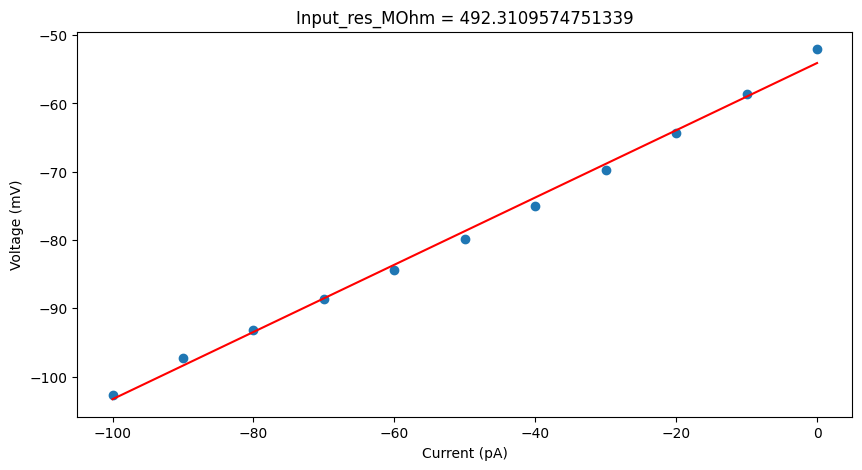

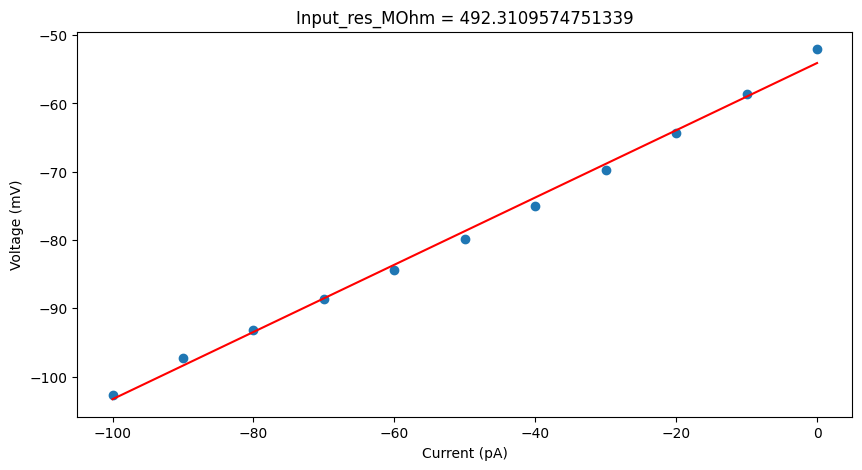

In [53]:
def create_plot_current_voltage (abf, abf_c, channel, channel_c, t1_c, t2_c, stim_start, stim_end):
    
    table_m = pd.DataFrame(columns=['Sweep', 
                                    'current_pA', 
                                    'steady_state_voltage_stimend'

                                 ])  
    
    # Loop function
    for sweep in abf.sweepList:  # To select a range of traces
        abf.setSweep(sweep, channel = channel)
        abf_c.setSweep(sweep, channel = channel_c)
        # Defines a trace and region of analysis
        trace = {'T': abf.sweepX*1000, # convert to ms
                 'V': abf.sweepY,
                 'I': abf_c.sweepC,
                 'stim_start' : [stim_start],
                 'stim_end' : [stim_end]}
        traces = [trace]
        
        currents = [] # Current value between t1 and t2 (ms) for each step
        t1 = int(t1_c*abf.dataPointsPerMs) 
        t2 = int(t2_c*abf.dataPointsPerMs)
        current_mean = np.average(abf_c.sweepC[t1:t2])

        # Output features
        feature_values = efel.getFeatureValues(traces,
                                               ['voltage', 'steady_state_voltage_stimend', 
                                                'current', 'time_constant', 
                                                'sag_amplitude', 
                                                'sag_ratio1', 'AP_amplitude'],
                                               raise_warnings=None)[0] # If true, returns warnings

        # Optional: create table from the results
        # Use [0] to extract the values from the Spikecount array
        
        length = len(table_m)
        if feature_values["AP_amplitude"] is None and current_mean <100:
            table_m.loc[length, 'Sweep'] = sweep
            table_m.loc[length, 'steady_state_voltage_stimend'] = feature_values['steady_state_voltage_stimend'][0]
            table_m.loc[length, 'current_pA'] = current_mean # [] to select the rows of current step
        elif feature_values["AP_amplitude"] is not None:
#        if feature_values["AP_amplitude"] is not None:
            if len(feature_values['AP_amplitude']) <1:
                table_m.loc[length, 'Sweep'] = sweep
                table_m.loc[length, 'steady_state_voltage_stimend'] = feature_values['steady_state_voltage_stimend'][0]
                table_m.loc[length, 'current_pA'] = current_mean # [] to select the rows of current step
            
    #print(table_m)

    fig = plt.figure(figsize=(10, 5))
    current = table_m["current_pA"].to_list()
    voltage = table_m["steady_state_voltage_stimend"].to_list()
    
    # I-V graph
    fig.tight_layout()
    fig.set_canvas(plt.gcf().canvas)


    ax = fig.add_subplot()
    ax.scatter(current, voltage)
    ax.set_xlabel('Current (pA)')
    ax.set_ylabel('Voltage (mV)')

    # Linear regression using the function polyfit (degree 1)
    m, b = np.polyfit(current, voltage, 1)
    # Plot regression line
    line = np.polyval([m, b], current)
    plt.plot(current, line, color='r')
    ax.set_title(f'Input_res_MOhm = {m *1000}')

    #print (f'Input_res_MOhm ={m *1000}') # Input resistance (MOhm)
    # Print the graph and the input resistance (GOhm)
    return(fig)
    #return(m)
    
#data='D:/Ken_data_analysis/PC_CA1_macaque_1y_2y/2_years/2y_M1/Membrane_properties/24415086_2y_M1_11.abf'
data='23414003.abf'
abf = pyabf.ABF(data)
abf_c = pyabf.ABF(data)

#Set channels
channel=0 #for recording
channel_c=1 #for current

# start= 0.0
# end= 3

#Current steps
t1_c=600
t2_c=601

#Start and end of stimulation (ms)
stim_start=115
stim_end=815
   
create_plot_current_voltage(abf, abf_c, channel, channel_c, t1_c, t2_c, stim_start, stim_end)

In [20]:
#PLOT CURRENT VOLTAGE FOR SPARE RECORDINGS 
#!! DO NOT USE FOR LOOPS!!

def create_plot_current_voltage (abf, abf_c, start, end, channel, channel_c, t1_c, t2_c, stim_start, stim_end):
    
    table_m = pd.DataFrame(columns=['Sweep', 
                                    'current_pA', 
                                    'steady_state_voltage_stimend',

                                 ])  
    
    # Loop function
    for sweep in abf.sweepList:  # To select a range of traces
        abf.setSweep(sweep, channel = channel)
        abf_c.setSweep(sweep, channel = channel_c)
        # Defines a trace and region of analysis
        trace = {'T': abf.sweepX*1000, # convert to ms
                 'V': abf.sweepY,
                 'I': abf_c.sweepC,
                 'stim_start' : [stim_start],
                 'stim_end' : [stim_end]}
        traces = [trace]
        
        currents = [] # Current value between t1 and t2 (ms) for each step
        t1 = int(t1_c*abf.dataPointsPerMs) 
        t2 = int(t2_c*abf.dataPointsPerMs)
        current_mean = np.average(abf_c.sweepC[t1:t2])

        # Output features
        feature_values = efel.getFeatureValues(traces,
                                               ['voltage', 'steady_state_voltage_stimend', 
                                                'current', 'time_constant', 
                                                'sag_amplitude', 
                                                'sag_ratio1', 'AP_amplitude'],
                                               raise_warnings=None)[0] # If true, returns warnings

        # Optional: create table from the results
        # Use [0] to extract the values from the Spikecount array
        
        length = len(table_m)
        if current_mean >-100 and current_mean <55:
            table_m.loc[length, 'Sweep'] = sweep
            table_m.loc[length, 'steady_state_voltage_stimend'] = feature_values['steady_state_voltage_stimend'][0]
            table_m.loc[length, 'current_pA'] = current_mean # [] to select the rows of current step
            
    #print(table_m)

    fig = plt.figure(figsize=(10, 5))
    current = table_m["current_pA"].to_list()
    voltage = table_m["steady_state_voltage_stimend"].to_list()
    
    # I-V graph
    fig.tight_layout()
    fig.set_canvas(plt.gcf().canvas)


    ax = fig.add_subplot()
    ax.scatter(current, voltage)
    ax.set_xlabel('Current (pA)')
    ax.set_ylabel('Voltage (mV)')

    # Linear regression using the function polyfit (degree 1)
    m, b = np.polyfit(current, voltage, 1)
    # Plot regression line
    line = np.polyval([m, b], current)
    plt.plot(current, line, color='r')
    ax.set_title(f'Input_res_MOhm = {m *1000}')

    #print (f'Input_res_MOhm ={m *1000}') # Input resistance (MOhm)
    # Print the graph and the input resistance (GOhm)
    return(fig)
    #return(m)
    
    
#data='D:/Ken_data/23d14/Mouse_B3/Sag_firing_rate/23d14082_M3_B15.abf'
data='D:/Ken_data/Adam/Sag_firing_rate/Mouse_B/2023_12_12_0073_B.abf'
abf = pyabf.ABF(data)
abf_c = pyabf.ABF(data)

start= 0.0
end= 3

channel=0 #for recording
channel_c=0 #for current

#Current steps
t1_c=600
t2_c=601

#Start and end of stimulation (ms)
stim_start=300
stim_end=1100

create_plot_current_voltage(abf, abf_c, start, end, channel, channel_c, t1_c, t2_c, stim_start, stim_end)

ValueError: ABF file does not exist: D:\Ken_data\Adam\Sag_firing_rate\Mouse_B\2023_12_12_0073_B.abf

In [4]:
t_a = 0.08
t_b = 0.10

In [5]:
#Membrane resting potential from RAMP Protocol
def membrane_potential_plot_and_value (abf, abf_c, t_a, t_b):

    #sampling_rate = cell.dataRate
    filename= data_path
    cell = pyabf.ABF(filename)
    sampling_rate = cell.dataRate

    avg_trace = np.empty([len(cell.sweepList), len(cell.sweepY)])
    t = cell.sweepX
    
#calculate the avarage trace
    for trace in cell.sweepList:
            cell.setSweep(trace, baseline=[0, 0.2])
            avg_trace[trace] = cell.sweepY

    avg_trace = np.mean(avg_trace, axis=0)

#run linear regression on K leak (t0-t1) portion of the trace

    t0 = int(t_a * sampling_rate)  #start for linear regression
    t1 = int(t_b * sampling_rate)  #end of  window for linear regression
    X = t[t0:t1]
    Y = avg_trace[t0:t1]
    
    X = ssm.add_constant(X)
    mod = ssm.OLS(Y, X)
    reg = mod.fit()

    leak = (reg.params[1] * t) + reg.params[0]
    idx = np.argwhere(np.diff(np.sign(avg_trace - leak))).flatten()
    command = cell.sweepC[idx[-2]] 

    
#plot avg trace and linear regression function    
    Ramp=plt.figure()
    plt.plot(t,avg_trace)
    plt.plot(t,leak, 'r-')
    plt.xlim([0.045,0.20])
    plt.ylim([-200, 200])
    plt.xlabel('time (s)')
    plt.ylabel('current (pA)')
    plt.title(f'Resting membrane potential= {command + 60}')
    
    return(Ramp)

#filename='23d12000_M1_A1.abf'
#abf = pyabf.ABF(filename)
#abf_c = pyabf.ABF(filename)

#membrane_potential_plot_and_value (abf, abf_c, t_a, t_b)

In [6]:
start_tau_ms = 360
end_tau_ms = 550
tau_expected = 30

In [7]:
def generate_tau_figures (abf, abf_c, start_tau_ms, end_tau_ms, tau_expected):

    # Number of sweeps
    num_sweeps = abf.sweepCount

    # Create an array to store the data
    all_sweeps = []

    # Loop through each sweep and store the data
    for sweep in range(num_sweeps):
        abf.setSweep(sweep)
        all_sweeps.append(abf.sweepY)

    # Convert to numpy array for easier manipulation
    all_sweeps = np.array(all_sweeps)

    # Calculate the average across all sweeps
    average_sweep = np.mean(all_sweeps, axis=0)

    # Plot the average sweep
    #Average_sweeps=plt.plot(abf.sweepX * 1000, average_sweep, label='Average Sweep')
    #plt.plot(abf.sweepX * 1000, average_sweep, label='Average Sweep')  # Convert x-axis to ms

    # Identify the region of interest for fitting (in ms)
    #start_ms = 350  # start time in ms
    #end_ms = 450    # end time in ms

    # Convert ms to seconds for indexing
    start_s = start_tau_ms / 1000
    end_s = end_tau_ms / 1000

    # Find the corresponding indices in the time array
    start_idx = np.where(abf.sweepX >= start_s)[0][0]
    end_idx = np.where(abf.sweepX <= end_s)[0][-1]

    # Extract the data in the region of interest
    t_fit = abf.sweepX[start_idx:end_idx] * 1000  # Convert to ms for fitting
    y_fit = average_sweep[start_idx:end_idx]


    # Define the exponential decay function
    def exp_decay(t, A, tau, C):
        return A * np.exp(-t / tau) + C

    # Calculate generic initial guesses for the parameters
    A_initial = max(y_fit) - min(y_fit)  # Difference between the max and min value in the region of interest
    tau_initial = tau_expected  # Reasonable starting point for tau (in ms)
    C_initial = min(y_fit)  # Minimum value in the region of interest

    initial_guess = [A_initial, tau_initial, C_initial]  # A = max-min, tau = 10 ms, C = min value

    # Print the initial guesses for validation
    #print(f"Initial guesses: A = {A_initial}, tau = {tau_initial}, C = {C_initial}")

    # Fit the exponential decay model to the data
    params, covariance = curve_fit(exp_decay, t_fit, y_fit, p0=initial_guess)

    # Extract the fitted parameters
    A, tau, C = params

    # Plot the fitted exponential decay
    # Plot the region of interest to validate
    Fitted_decay = plt.figure()
    plt.plot(t_fit, y_fit, 'b-', label='Region of Interest')
    plt.plot(t_fit, exp_decay(t_fit, *params), 'r--', label=f'Fitted Exponential Decay\nτ = {tau:.2f} ms')
    plt.xlabel("Time (ms)")
    plt.ylabel("Voltage")
    plt.title("Region of Interest for Fitting")
    plt.legend()
    #plt.show()
    
    Average_sweeps=plt.figure()
    plt.plot(abf.sweepX * 1000, average_sweep, label='Average Sweep')
    plt.plot(t_fit, exp_decay(t_fit, *params), 'r--', label=f'Fitted Exponential Decay\nτ = {tau:.2f} ms')
    plt.title('Average Sweep')
    plt.legend()
    #plt.show()

    # Print the membrane time constant in milliseconds
    #print(f"Membrane time constant (τ): {tau:.2f} ms")
    return(Average_sweeps)

#data='D:/Ken_data/23d14/Mouse_B3/Membrane_constant/23d14038_M3_B8.abf'
data='D:/Ken_data_analysis/PC_CA1_macaque_1y_2y/4_years/4y_M4/Membrane_constant/24506054_4y_M4_9.abf'
abf = pyabf.ABF(data)
abf_c = pyabf.ABF(data)

generate_tau_figures (abf, abf_c, start_tau_ms, end_tau_ms, tau_expected)

ValueError: ABF file does not exist: D:\Ken_data_analysis\PC_CA1_macaque_1y_2y\4_years\4y_M4\Membrane_constant\24506054_4y_M4_9.abf

In [278]:
def generate_firing_rate_table (abf, abf_c, start, end, channel, channel_c, t1_c, t2_c, stim_start, stim_end):
    firing_rate_table = pd.DataFrame(columns=['Sweep', 'current_pA', 'Spikecount',
                                  'steady_state_voltage_stimend'
                                 ])  
    #num_of_traces = 25

    # Loop function
    for sweep in abf.sweepList: #[0:num_of_traces]:  # To select a range of traces
        abf.setSweep(sweep, channel = channel)
        abf_c.setSweep(sweep, channel = channel_c)
        # Defines a trace and region of analysis
        trace = {'T': abf.sweepX*1000, #convert to ms
                 'V': abf.sweepY,
                 'I': abf_c.sweepC,
                 'stim_start' : [stim_start],
                 'stim_end' : [stim_end]}
        traces = [trace]
        
        currents = [] # Current value between t1 and t2 (ms) for each step
        t1 = int(t1_c*abf.dataPointsPerMs) 
        t2 = int(t2_c*abf.dataPointsPerMs)
        current_mean = np.average(abf_c.sweepC[t1:t2])

        # Output features
        feature_values = efel.getFeatureValues(traces,
                                               ['voltage', 'steady_state_voltage_stimend', 
                                                'Spikecount',
                                                'sag_amplitude', 
                                                'sag_ratio1', 'AP_amplitude'],
                                               raise_warnings=None)[0] # If true, returns warnings

        # Optional: create table from the results
        # Use [0] to extract the values from the Spikecount array
        
        length = len(firing_rate_table)
        if feature_values["AP_amplitude"] is not None: 
            firing_rate_table.loc[length, 'Sweep'] = sweep
            firing_rate_table.loc[length, 'steady_state_voltage_stimend'] = feature_values['steady_state_voltage_stimend'][0]
            firing_rate_table.loc[length, 'Spikecount'] = feature_values['Spikecount']
            firing_rate_table.loc[length, 'current_pA'] = current_mean # [] to select the rows of current step
            firing_rate_table.loc[length, 'Firng_rate_Hz'] = (firing_rate_table.loc[length, 'Spikecount']/(stim_end-stim_start)*1000)

    return (firing_rate_table)

#data= 'E:/Ken_data/23d14/Mouse_B3/Firing_properties/23d14026_M3_B5.abf'
#abf = pyabf.ABF(data)
#abf_c = pyabf.ABF(data)

#generate_firing_rate_table (abf, abf_c, start, end, channel, channel_c, t1_c, t2_c, stim_start, stim_end)


In [120]:
def generate_adaptation_table(abf, abf_c, start, end, channel, channel_c, t1_c, t2_c, stim_start, stim_end):
    
    adaptation_table = pd.DataFrame()

    # Loop function to analyze each voltage and current trace of the file
    for sweep in abf.sweepList:
        abf.setSweep(sweep)
        abf_c.setSweep(sweep, channel = channel_c)

        time = abf.sweepX
        voltage = abf.sweepY
        current = abf_c.sweepC

        currents = [] # Current value between t1 and t2 (ms) for each step
        t1 = int(t1_c*abf.dataPointsPerMs) 
        t2 = int(t2_c*abf.dataPointsPerMs)
        current_mean = np.average(abf_c.sweepC[t1:t2])

        sfx = SpikeFeatureExtractor(start=start, end=end, filter=None)
        sfx_results = sfx.process(time, voltage, current)
        stfx = SpikeTrainFeatureExtractor (start=start, end=end)
        stfx_results = stfx.process(time, voltage, current, sfx_results)

        # Create a table with the stfx results
        length = len(adaptation_table)

        if stfx_results ['avg_rate'] > 0:
            adaptation_table.loc[length, 'Sweep'] = sweep
            #adaptation_table.loc[length, 'Current_step'] = current_mean
            adaptation_table.loc[length, 'adaptation'] = stfx_results ["adapt"]
            adaptation_table.loc[length, 'ISI_CV'] = stfx_results ["isi_cv"]#NOT sure what this is COEFFICIENT OF VARIATION
            adaptation_table.loc[length, 'ISI_mean_ms'] = stfx_results ["mean_isi"]*1000
            adaptation_table.loc[length, 'ISI_first_ms'] = stfx_results ["first_isi"]*1000
            #table_1.loc[length, 'ISI_last_ms'] = stfx_results ["last_isi"]*1000
        
            #table.loc[length, 'Rheobase'] = stfx_results ["rheobase"]
            #table.loc[length, 'Spikecount'] = stfx_results ['Spikecount_stimint']
    
    return(adaptation_table)

#data= 'E:/Ken_data/23d15/Mouse_A3/Sag_firing_rate/23d15002_M3_A1.abf'
#abf = pyabf.ABF(data)
#abf_c = pyabf.ABF(data)
generate_adaptation_table(abf, abf_c, start, end, channel, channel_c, t1_c, t2_c, stim_start, stim_end)

,Sweep,adaptation,ISI_CV,ISI_mean_ms,ISI_first_ms
0,10.0,0.013206,0.154414,37.300000,17.75
1,11.0,0.006170,0.096702,16.395763,8.60
2,12.0,0.004014,0.071703,11.149432,6.45
3,13.0,0.001633,0.063117,8.365678,5.90
4,14.0,0.001235,0.047265,7.043262,5.20
5,15.0,0.000850,0.036326,6.134877,4.60
6,16.0,0.000657,0.034246,5.697126,4.50
7,17.0,0.000866,0.035202,5.490884,4.10
8,18.0,0.000744,0.034138,5.183333,3.95
9,19.0,0.000611,0.032430,4.861463,3.70


In [13]:
def merge_firing_rate_adaptation_tables(firing_rate_table, adaptation_table):
    table_firing_adaptation = pd.merge(firing_rate_table, adaptation_table, on='Sweep')
    return(table_firing_adaptation)

In [240]:
def generate_sag_table(abf, abf_c, start, end, channel, channel_c, t1_c, t2_c, stim_start, stim_end):
    sag_table = pd.DataFrame(columns=['Sweep', 'current_pA', 'steady_state_voltage_stimend',
                                  'voltage_delta', 
                                  'sag_amplitude', 'sag_time_constant',
                                   #'sag_ratio',   
                                  'minimum_voltage'
                                 ])  
    #num_of_traces = 25

    # Loop function
    for sweep in abf.sweepList: #[0:num_of_traces]:  # To select a range of traces
        abf.setSweep(sweep, channel = channel)
        abf_c.setSweep(sweep, channel = channel_c)
        # Defines a trace and region of analysis
        trace = {'T': abf.sweepX*1000, #convert to ms
                 'V': abf.sweepY,
                 'I': abf_c.sweepC,
                 'stim_start' : [stim_start],
                 'stim_end' : [stim_end]}
        traces = [trace]
        
        currents = [] # Current value between t1 and t2 (ms) for each step
        t1 = int(t1_c*abf.dataPointsPerMs) 
        t2 = int(t2_c*abf.dataPointsPerMs)
        current_mean = np.average(abf_c.sweepC[t1:t2])

        # Output features
        feature_values = efel.getFeatureValues(traces,
                                               ['voltage', 'steady_state_voltage_stimend', 
                                                'current', 'time_constant', 'voltage_base',
                                                'sag_amplitude', 'sag_time_constant', 'sag_ratio2',
                                                'sag_ratio1', 'AP_amplitude'],
                                               raise_warnings=None)[0] # If true, returns warnings

        # Optional: create table from the results
        # Use [0] to extract the values from the Spikecount array
        
        length = len(sag_table)
        if current_mean<0: 
            sag_table.loc[length, 'Sweep'] = sweep
            sag_table.loc[length, 'steady_state_voltage_stimend'] = feature_values['steady_state_voltage_stimend'][0]
            sag_table.loc[length, 'voltage_delta'] = (feature_values['steady_state_voltage_stimend']-feature_values['voltage'])[0]
            sag_table.loc[length, 'current_pA'] = current_mean # [] to select the rows of current step
            sag_table.loc[length, 'voltage_base'] = feature_values['voltage_base']

            #if (table.loc[length, 'current_pA']  >= -80) & (table.loc[length, 'current_pA']  < 0):
            #    table.loc[length, 'input_resistance_Gohm'] = (table.loc[length, 'voltage_delta']/table.loc[length, 'current_pA'])
            #    if (feature_values['time_constant'] is not None):
            #        table.loc[length, 'time_constant'] = feature_values['time_constant'][0]
            #       table.loc[length, 'capacitance_pF'] = (feature_values['time_constant']/table.loc[length, 'input_resistance_Gohm'])[0]

            sag_table.loc[length, 'minimum_voltage'] = feature_values['voltage'].min()
            sag_table.loc[length, 'sag_ratio_1'] = feature_values['sag_ratio1']
            sag_table.loc[length, 'sag_ratio_2'] = feature_values['sag_ratio2']
            sag_table.loc[length, 'sag_time_constant'] = feature_values['sag_time_constant']
            sag_table.loc[length, 'sag_amplitude'] = feature_values['sag_amplitude']

    return (sag_table)
data= 'E:/Ken_data/23d15/Mouse_A3/Sag_firing_rate/23d15002_M3_A1.abf'
abf = pyabf.ABF(data)
abf_c = pyabf.ABF(data)

channel=0 #for recording
channel_c=0 #for current

#Current steps
t1_c=600
t2_c=601

#Start and end of stimulation (ms)
stim_start=305
stim_end=1305 

generate_sag_table(abf, abf_c, start, end, channel, channel_c, t1_c, t2_c, stim_start, stim_end)

,Sweep,current_pA,steady_state_voltage_stimend,voltage_delta,sag_amplitude,minimum_voltage,voltage_base,sag_ratio_1,sag_ratio_2
0,0.0,-350.0,-99.1796,-28.3331,2.64226,-101.822,-70.897129,0.085441,0.914559
1,1.0,-300.0,-94.2733,-25.4409,3.36768,-97.641,-68.859355,0.117008,0.882992
2,2.0,-250.0,-90.9305,-22.5864,3.23148,-94.162,-68.254657,0.124732,0.875268
3,3.0,-200.0,-87.3412,-19.287,3.18918,-90.5304,-67.904505,0.140953,0.859047
4,4.0,-150.0,-83.1568,-15.5604,2.87224,-86.029,-67.621642,0.156037,0.843963
5,5.0,-100.0,-79.3048,-11.098,2.07033,-81.3751,-67.969193,0.154434,0.845566
6,6.0,-50.0,-74.5007,-6.37019,1.03032,-75.531,-68.145894,0.139513,0.860487


In [111]:
def merge_firing_rate_adaptation_sag_table (table_firing_adaptation,sag_table):
    table_firing_rate_adaptation_sag=pd.concat([table_firing_adaptation,sag_table], axis=1, join='outer')# All DATA
    return (table_firing_rate_adaptation_sag)

In [17]:
def create_and_add_to_excel(file_name, iterator_number, cell_file_name, table): 
    
    # Name the sheet 
    sheetname = f'cell {cell_file_name[:-4]}'
    # Convert the file name to an excel file
    full_file_name = file_name + '.xlsx'
    
    # If its the first cell, create the file
    if iterator_number == 0:
        table.to_excel(full_file_name, sheet_name= sheetname, index=False) 
        
    # If the file already exists, add a new sheet to it
    else:
        with pd.ExcelWriter(full_file_name, mode = 'a') as writer:
            table.to_excel(writer, sheet_name= sheetname, index=False) 

        writer.close()

# Example use of function
# for k in range(0,3):
#    create_and_add_to_excel('cat', k, table_final)

## The Big Loops


In [17]:
#Set varible (Chage depending on type of recording)

##INPUT RES SHORT
#Total lenght of the recording (s)
#start= 0.0
#end= 3

#Set channels
#channel=0 #for recording
#channel_c=0 #for current

#Current steps
#t1_c=600
#t2_c=601

#Start and end of stimulation (ms)
#stim_start=305
#stim_end=1305 

#FIRING PROPERTIES
#Total lenght of the recording (s)
#start= 0.0
#end= 1.9

#Set channels
channel=0 #for recording
channel_c=0 #for current

#Current steps
t1_c=600
t2_c=601

#Start and end of stimulation (ms)
stim_start=256
stim_end=1056

#MEMBRANE
#Total lenght of the recording (s)
start= 0.0
end= 3

#Set channels
channel=0 #for recording
channel_c=0 #for current

#Current steps
t1_c=600
t2_c=601

#Start and end of stimulation (ms)
stim_start=528
stim_end=2528

#Set input folder, output folder, file name
input_folder ='E:/Ken_data/23d12/Mouse_A1/Membrane_properties'
#input_folder = 'C:/Users/giupiz/OneDrive - Karolinska Institutet/Desktop/041024A/Analysis'
#output_file_name_AP = '23d12_M1_B_Firing_properties'
output_file_name_M ='23d15_M3_A_Membrane_properties_new'
#output_file_name_firing_adaptation_sag = '23d12_M1_A_firing_adaptation_sag'
new_folder_location ='E:/Ken_data/23d12/Mouse_A1/Membrane_properties/'
#new_folder_location = 'C:/Users/giupiz/OneDrive - Karolinska Institutet/Desktop/041024A/Analysis/'


2024_08_28_0001_S1R-CA1pyr-PV2.abf Successfully Executed
2024_08_28_0008_S1L-CA1pyr-PV1.abf Failed because:
Optimal parameters not found: Number of calls to function has reached maxfev = 800.
2024_08_28_0016_S2R-CA1pyr-PV1.abf Successfully Executed
2024_08_28_0022_S2L-CA1pyr-PV1.abf Successfully Executed
2024_08_28_0028_S3R-CA1pyr-PV1.abf Successfully Executed
2024_08_28_0033_S3R-CA1pyr-PV2.abf Successfully Executed
2024_08_28_0040_S3L-CA1pyr-PV1.abf Failed because:
Optimal parameters not found: Number of calls to function has reached maxfev = 800.
2024_08_28_0047_S4R-CA1pyr-PV1.abf Failed because:
Optimal parameters not found: Number of calls to function has reached maxfev = 800.
2024_08_29_0002_S1L-CA1pyr-PV1.abf Failed because:
Optimal parameters not found: Number of calls to function has reached maxfev = 800.
2024_08_29_0012_S2L-CA1or-PV1.abf Successfully Executed


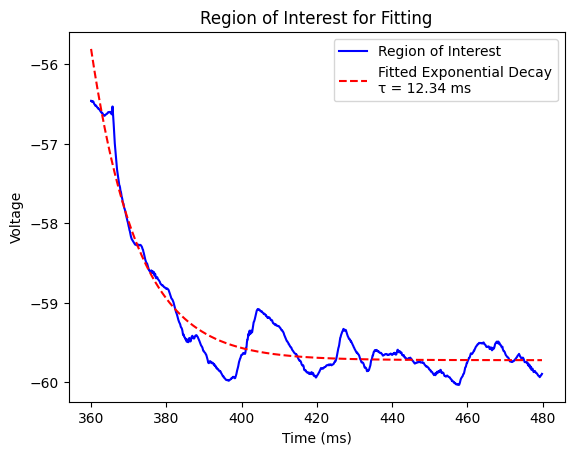

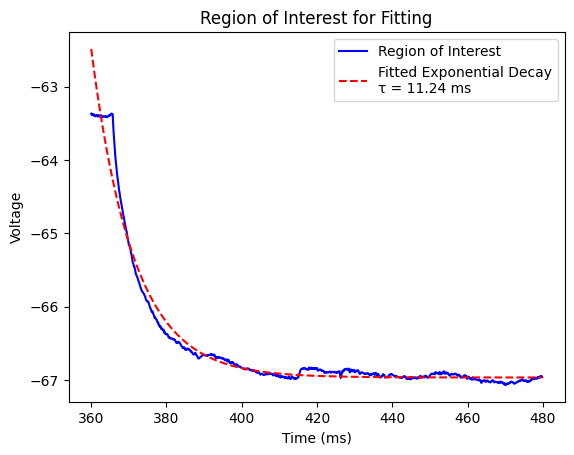

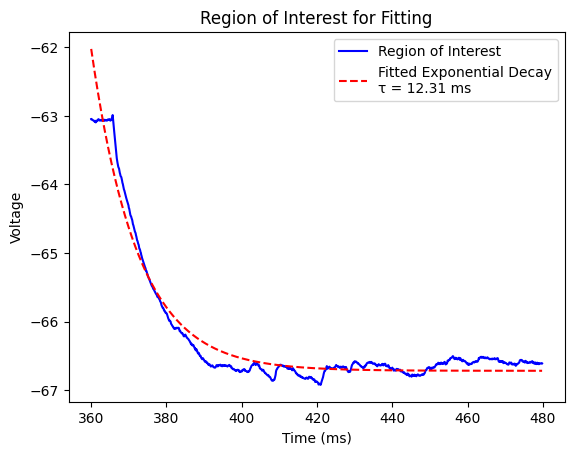

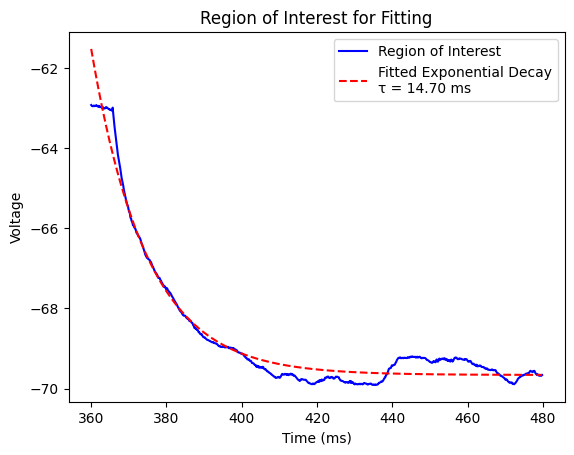

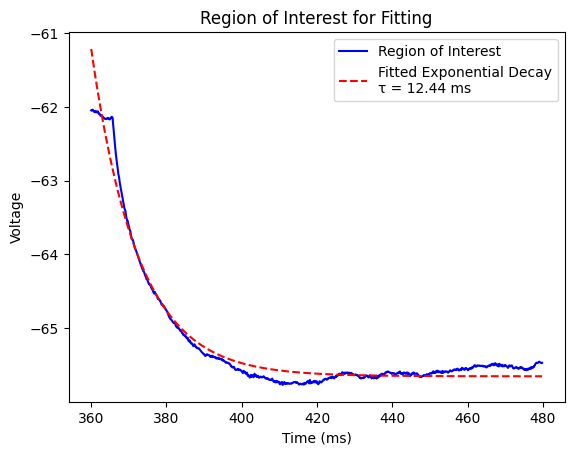

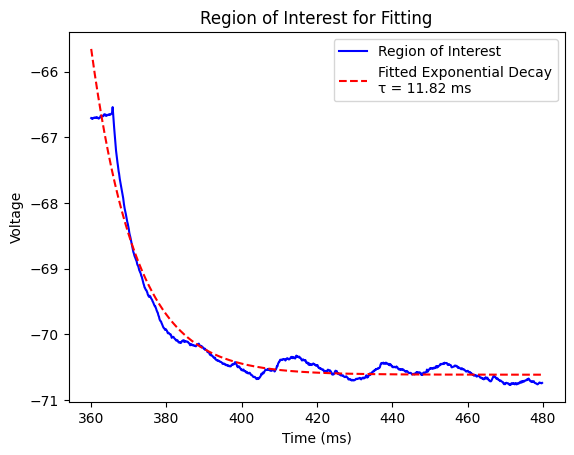

In [12]:
#Membrane time constant
#ALL TRACE
#start_tau_ms = 360
#end_tau_ms = 760
#tau_expected = 30

#ONLY BEGINNING
start_tau_ms = 360
end_tau_ms = 480
tau_expected = 30

# ------------------------ For Input ------------------------
# Define the path to the directory
input_path = 'F:/Ken_Data_Analysis/Adam_data/3-Ic-TimeConstant'
# ------------------------ For Output ------------------------
output_file_name= 'Membrane_constant_short'
# Establishes location for new folder  (same name as the excel file name)
new_folder_location = 'F:/Ken_Data_Analysis/Adam_data/3-Ic-TimeConstant/'

# ------------------------------------   
# Automatic Input 
# Get the list of all files in the directory
dir_list = os.listdir(input_path)
    
# Prepare Output
folder_path = new_folder_location + '/' + output_file_name
final_output_file_name = folder_path + '/' + output_file_name

# Checks if the folder exists, otherwise creates it
if not os.path.exists(folder_path): 
    os.makedirs(folder_path)
    
# Enumerate is a special loop, instead of producing the values, it produces the value and the iterator number
# In this example, file[0] is the iterator number, file[1] is the actual value
for file in enumerate(dir_list):
    
    # Only attempt analysis of a file if it is an abf file (just incase there's some other file there)
    if file[1].endswith('.abf'):
        
        # Define the full file path
        data_path = input_path + '/' + file[1]
        
        # Ingest data 
        abf = pyabf.ABF(data_path)
        abf_c = pyabf.ABF(data_path)
        
        try: 
            # Manipulate Data, Generate and Save Plots
            Membrane_time_constant = generate_tau_figures (abf, abf_c, start_tau_ms, end_tau_ms, tau_expected)
            Membrane_time_constant.savefig(folder_path + f"/{file[1]}_tau.png", dpi=300)
            plt.close()
            
            print(f"{file[1]} Successfully Executed")

        except Exception as e:
            print(f"{file[1]} Failed because:")
            print(e)

In [39]:
#Membrane resting potential with ramp
t_a=0.08
t_b=0.10

# ------------------------ For Input ------------------------
# Define the path to the directory
input_path = 'D:/Ken_data_analysis/H3K4_collaboration_analysis/Adam/Ramp/Mouse_B'
# ------------------------ For Output ------------------------
output_file_name= 'M_B_Adam_ramp'
# Establishes location for new folder  (same name as the excel file name)
new_folder_location = 'D:/Ken_data_analysis/H3K4_collaboration_analysis/Adam/Ramp/Mouse_B/'

# ------------------------------------   
# Automatic Input 
# Get the list of all files in the directory
dir_list = os.listdir(input_path)
    
# Prepare Output
folder_path = new_folder_location + '/' + output_file_name
final_output_file_name = folder_path + '/' + output_file_name

# Checks if the folder exists, otherwise creates it
if not os.path.exists(folder_path): 
    os.makedirs(folder_path)
    
# Enumerate is a special loop, instead of producing the values, it produces the value and the iterator number
# In this example, file[0] is the iterator number, file[1] is the actual value
for file in enumerate(dir_list):
    
    # Only attempt analysis of a file if it is an abf file (just incase there's some other file there)
    if file[1].endswith('.abf'):
        
        # Define the full file path
        data_path = input_path + '/' + file[1]
        
        # Ingest data 
        abf = pyabf.ABF(data_path)
        abf_c = pyabf.ABF(data_path)
        
        try: 
            # Manipulate Data, Generate and Save Plots
            Membrane_resting_potential = membrane_potential_plot_and_value (abf, abf_c, t_a, t_b)
            Membrane_resting_potential.savefig(folder_path + f"/{file[1]}_ramp.png", dpi=300)
            plt.close()
            
            print(f"{file[1]} Successfully Executed")

        except Exception as e:
            print(f"{file[1]} Failed because:")
            print(e)

2023_12_12_0007_B-S1L-R1_CA1pyr.abf Successfully Executed
2023_12_12_0035_B-S2R-R2_CA1rad.abf Successfully Executed
2023_12_12_0042_B-S2R-R4_CA3pyr.abf Successfully Executed
2023_12_12_0062_B-S3R-R1_CA1pyr.abf Successfully Executed
2023_12_12_0069_B-S3R-R3_CA3pyr.abf Successfully Executed
2023_12_13_0021_B-S1R-R2_CA1pyr.abf Successfully Executed
2023_12_13_0027_B-S1R-R3_CA3pyr.abf Successfully Executed
2023_12_13_0033_B-S1R-R4_DGgr.abf Successfully Executed
2023_12_13_0048_B-S2L-R1_CA1pyr.abf Successfully Executed
2023_12_13_0055_B-S2L-R3_DGgr.abf Successfully Executed
2023_12_13_0069_B-S3R-R1_CA1pyr.abf Successfully Executed
2023_12_14_0007_B-S1L-R3_CA1pyr.abf Successfully Executed
2023_12_14_0014_B-S2L-R3_CA1pyr.abf Successfully Executed
2023_12_14_0021_B-S2L-R4_CA3pyr .abf Successfully Executed
2023_12_14_0029_B-S3L-R1_CA1pyr.abf Successfully Executed
2023_12_14_0036_B-S3L-R2_CA1pyr .abf Successfully Executed
2023_12_14_0047_B-S3L-R4_CA3pyr.abf Successfully Executed
2023_12_14_0055_

In [89]:
#AP STUDY
# ------------------------ For Input ------------------------
# Define the path to the directory
input_path = input_folder
# ------------------------ For Output ------------------------
output_file_name_AP = output_file_name_AP
# Establishes location for new folder  (same name as the excel file name)
new_folder_location = new_folder_location

# ------------------------------------   
# Automatic Input 
# Get the list of all files in the directory
dir_list = os.listdir(input_path)
    
# Prepare Output
folder_path = new_folder_location + '/' + output_file_name_AP
final_output_file_name_AP = folder_path + '/' + output_file_name_AP

# Checks if the folder exists, otherwise creates it
if not os.path.exists(folder_path): 
    os.makedirs(folder_path)
    
# Enumerate is a special loop, instead of producing the values, it produces the value and the iterator number
# In this example, file[0] is the iterator number, file[1] is the actual value
for file in enumerate(dir_list):
    
    # Only attempt analysis of a file if it is an abf file (just incase there's some other file there)
    if file[1].endswith('.abf'):
        
        # Define the full file path
        data_path = input_path + '/' + file[1]
        
        # Ingest data 
        abf = pyabf.ABF(data_path)
        abf_c = pyabf.ABF(data_path)
        
        try: 
            # Manipulate Data, Generate and Save Plots
            firing_currents = create_plot_firing_current(abf, abf_c, start, end, channel, channel_c, t1_c, t2_c, stim_start, stim_end)
            firing_currents.savefig(folder_path + f"/{file[1]}_firing_current.png", dpi=300)
            plt.close()
            
            input_resistance = create_plot_input_resistance(abf, abf_c)
            input_resistance.savefig(folder_path + f"/{file[1]}_input_resistance.png", dpi=300)
            plt.close()
            
            input_resistance_currents = create_plot_input_resistance_currents(abf, abf_c)
            input_resistance_currents.savefig(folder_path + f"/{file[1]}_input_resistance_currents.png", dpi=300)
            plt.close()
            
            # Generate tables
            ipfx_table = generate_ipfx_table(abf, abf_c, start, end, channel, channel_c, t1_c, t2_c, stim_start, stim_end)
            ap_table =  generate_AP_table(abf, abf_c, start, end, channel, channel_c, t1_c, t2_c, stim_start, stim_end)
            final_table = merge_ipfx_ap_tables(ipfx_table, ap_table)
        
            # Export table data into excel
            create_and_add_to_excel(final_output_file_name_AP, file[0], file[1], final_table)
            
            print(f"{file[1]} Successfully Executed")

        except Exception as e:
            print(f"{file[1]} Failed because:")
            print(e)


23d12058_M1_B9.abf Successfully Executed
23d12069_M1_B11.abf Successfully Executed


C:\Users\giupiz\AppData\Local\anaconda3\envs\ephys\lib\site-packages\ipfx\spike_features.py:87: RuntimeWarning: invalid value encountered in less
  width_levels[width_levels < v[spike_indexes]] = thresh_to_peak_levels[width_levels < v[spike_indexes]]


23d12100_M1_B16.abf Successfully Executed
23d12106_M1_B17.abf Successfully Executed


In [288]:
#MEMBRANE PROPERTIES
# ------------------------ For Input ------------------------
# Define the path to the directory
input_path = input_folder
# ------------------------ For Output ------------------------
output_file_name_M = output_file_name_M
# Establishes location for new folder  (same name as the excel file name)
new_folder_location = new_folder_location

# ------------------------------------   
# Automatic Input 
# Get the list of all files in the directory
dir_list = os.listdir(input_path)
    
# Prepare Output
folder_path = new_folder_location + '/' + output_file_name_M
final_output_file_name = folder_path + '/' + output_file_name_M

# Checks if the folder exists, otherwise creates it
if not os.path.exists(folder_path): 
    os.makedirs(folder_path)
    
# Enumerate is a special loop, instead of producing the values, it produces the value and the iterator number
# In this example, file[0] is the iterator number, file[1] is the actual value
for file in enumerate(dir_list):
    
    # Only attempt analysis of a file if it is an abf file (just incase there's some other file there)
    if file[1].endswith('.abf'):
        
        # Define the full file path
        data_path = input_path + '/' + file[1]
        
        # Ingest data 
        abf = pyabf.ABF(data_path)
        abf_c = pyabf.ABF(data_path)
        
        try: 
       
            # Manipulate Data, Generate and Save Plots  
            current_voltage = create_plot_current_voltage (abf, abf_c, start, end, channel, channel_c, t1_c, t2_c, stim_start, stim_end)
            current_voltage.savefig(folder_path + f"/{file[1]}_firing_current.png", dpi=300)
            plt.close()
            
            # Generate tables
            table_membrane_properties = generate_membrane_potential_table(abf, abf_c, start, end, channel, channel_c, t1_c, t2_c, stim_start, stim_end)
            
            # Export table data into excel
            create_and_add_to_excel(final_output_file_name, file[0], file[1], table_membrane_properties)
            print(f"{file[1]} Successfully Executed")

        except Exception as e:
            print(f"{file[1]} Failed because:")
            print(e)


C:\Users\giupiz\AppData\Local\anaconda3\envs\ephys\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\giupiz\AppData\Local\anaconda3\envs\ephys\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in double_scalars


23d12009_M1_A2.abf Successfully Executed
23d12015_M1_A3.abf Successfully Executed
23d12022_M1_A4.abf Successfully Executed
23d12031_M1_A5.abf Successfully Executed
23d12037_M1_A6.abf Successfully Executed
23d12044_M1_A7.abf Successfully Executed
23d12051_M1_A8.abf Successfully Executed
23d12081_M1_A13.abf Successfully Executed


In [128]:
#FIRING_RATE_ADAPTATION_SAG
# ------------------------ For Input ------------------------
# Define the path to the directory
input_path = input_folder
# ------------------------ For Output ------------------------
output_file_name_AP = output_file_name_firing_adaptation_sag
# Establishes location for new folder  (same name as the excel file name)
new_folder_location = new_folder_location

# ------------------------------------   
# Automatic Input 
# Get the list of all files in the directory
dir_list = os.listdir(input_path)
    
# Prepare Output
folder_path = new_folder_location + '/' + output_file_name_AP
final_output_file_name_AP = folder_path + '/' + output_file_name_AP

# Checks if the folder exists, otherwise creates it
if not os.path.exists(folder_path): 
    os.makedirs(folder_path)
    
# Enumerate is a special loop, instead of producing the values, it produces the value and the iterator number
# In this example, file[0] is the iterator number, file[1] is the actual value
for file in enumerate(dir_list):
    
    # Only attempt analysis of a file if it is an abf file (just incase there's some other file there)
    if file[1].endswith('.abf'):
        
        # Define the full file path
        data_path = input_path + '/' + file[1]
        
        # Ingest data 
        abf = pyabf.ABF(data_path)
        abf_c = pyabf.ABF(data_path)
        
        try:
            # Generate tables
            firing_rate_table = generate_firing_rate_table (abf, abf_c, start, end, channel, channel_c, t1_c, t2_c, stim_start, stim_end)
            adaptation_table =  generate_adaptation_table(abf, abf_c, start, end, channel, channel_c, t1_c, t2_c, stim_start, stim_end)
            sag_table =  generate_sag_table(abf, abf_c, start, end, channel, channel_c, t1_c, t2_c, stim_start, stim_end)
            firing_adaptation_table = merge_firing_rate_adaptation_tables(firing_rate_table, adaptation_table)
            firing_adaptation_sag_table = merge_firing_rate_adaptation_sag_table (firing_adaptation_table, sag_table)
        
            # Export table data into excel
            create_and_add_to_excel(final_output_file_name_AP, file[0], file[1], firing_adaptation_sag_table)
            
            print(f"{file[1]} Successfully Executed")

        except Exception as e:
            print(f"{file[1]} Failed because:")
            print(e)


23d15002_M3_A1.abf Successfully Executed
23d15008_M3_A2.abf Successfully Executed
23d15014_M3_A3.abf Successfully Executed
23d15019_M3_A4.abf Successfully Executed
23d15024_M3_A5.abf Successfully Executed
23d15030_M3_A6.abf Failed because:
'Sweep'
23d15031_M3_A6_SPARE.abf Successfully Executed


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)


23d15037_M3_A7.abf Successfully Executed
23d15045_M3_A8.abf Successfully Executed
23d15051_M3_A9.abf Successfully Executed
23d15057_M3_A10_LOST.abf Failed because:
'Sweep'
23d15062_M3_A11.abf Successfully Executed
23d15068_M3_A12.abf Successfully Executed
23d15077_M3_A14.abf Successfully Executed
23d15082_M3_A15.abf Successfully Executed
23d15088_M3_A16.abf Successfully Executed


INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair


23d15094_M3_A17.abf Successfully Executed
23d15100_M3_A18.abf Successfully Executed
23d15106_M3_A19.abf Successfully Executed
23d15114_M3_A21.abf Successfully Executed


In [ ]:
x = [1]
print(x)

def add_1(x):
    x.append(1)
    return x

y = add_1(x)
print(y)
print(x)

In [ ]:
x = 1
print(x)

def add_1(x):
    x += 1
    return x

y = add_1(x)
print(y)
print(x)